# nDATAu Datathon Notebook

---

<a name="#Daftar-Isi"></a>
### Daftar Isi

1. **[Pendahuluan](#Pendahuluan)**
2. **[Import Libraries](#Import-Libraries)**
3. **[Preprocessing](#Preprocessing)**
    -  ***[Data Collection](#Data-Collection)***
    -  ***[Data Transformation (Feature Engineering)](#Data-Transformation-(Feature-Engineering))***
    -  ***[Data Integration](#Data-Integration)***
    -  ***[Data Modelling Preparation](#Data-Modelling-Preparation)***
    -  ***[Data Cleaning](#Data-Cleaning)***
    -  ***[Data Splitting](#Data-Splitting)***
4. **[Exploratory Data Analysis](#Exploratory-Data-Analysis)**
    - ***[Dataset Train](#Dataset-Train)***
    - ***[Dataset Test](#Dataset-Test)***
    - ***[Dataset Non-Borrower](#Dataset-Non-Borrower)***
    - ***[Dataset Loan Activities](#Dataset-Loan-Activities)***
5. **[Modeling](#Modeling)**
    -  ***[Model Selection](#Model-Selection)***
    -  ***[Hyperparameter Tuning](#Hyperparameter-Tuning)***
    -  ***[Model Training](#Model-Training)***
    -  ***[Model Evaluation](#Model-Evaluation)***
    -  ***[Prediction](#Prediction)***
6. **[Analisis dan Pembahasan Hasil](#Analisis-dan-Pembahasan-Hasil)**
    -  ***[Model Performance](#Model-Performance)***
    -  ***[Comparison with Baseline](#Comparison-with-Baseline)***
    -  ***[Interpretation of Results](#Interpretation-of-Results)***
7. **[Kesimpulan](#Kesimpulan)**



---
<a name="Pendahuluan"></a>
## Pendahuluan

Machine learning sudah menjadi teknologi yang sangat dekat dengan kehidupan manusia. Pada kompetisi ini, peserta diuji dengan mengembangkan model *machine learning* untuk mendeteksi *fraud* pada pengguna *platform fintech*. *Notebook* ini berisi penjelasan mengenai analisa dan pemrosesan data termasuk modeling yang dilakukan.

Model akan dinilai berdasarkan metrik *average precision*, yang memberikan gambaran mengenai kemampuan model dalam mengklasifikasikan label fraud secara tepat. Pada kali ini kami akan menggunakan teknik rekayasa fitur yang telah terintegrasi dalam pipeline pemrosesan data, serta teknik pembelajaran mesin lanjutan untuk memaksimalkan skor dari *average precision*.

[Back To Top](#Daftar-Isi)

---
<a name="Import-Libraries"></a>
## Import Libraries

In [21]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import average_precision_score, roc_auc_score, f1_score, precision_score, recall_score, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

[Back To Top](#Daftar-Isi)

---
<a name="Preprocessing"></a>
## Preprocessing

<a name="#Data-Collection"></a>
### Data Collection

In [22]:
# Memuat dataset
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
loan_activities_df = pd.read_csv('loan_activities.csv')
non_borrower_user_df = pd.read_csv('non_borrower_user.csv')

# Menampilkan informasi tiap dataset untuk memastikan data telah dimuat
print("Train Dataset Info:")
print(train_df.info())
print("\nTest Dataset Info:")
print(test_df.info())
print("\nLoan Activities Dataset Info:")
print(loan_activities_df.info())
print("\nNon-Borrower User Dataset Info:")
print(non_borrower_user_df.info())

Train Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857899 entries, 0 to 857898
Data columns (total 19 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  857899 non-null  int64  
 1   pc0      857899 non-null  float64
 2   pc1      857899 non-null  float64
 3   pc2      857899 non-null  float64
 4   pc3      857899 non-null  float64
 5   pc4      857899 non-null  float64
 6   pc5      857899 non-null  float64
 7   pc6      857899 non-null  float64
 8   pc7      857899 non-null  float64
 9   pc8      857899 non-null  float64
 10  pc9      857899 non-null  float64
 11  pc10     857899 non-null  float64
 12  pc11     857899 non-null  float64
 13  pc12     857899 non-null  float64
 14  pc13     857899 non-null  float64
 15  pc14     857899 non-null  float64
 16  pc15     857899 non-null  float64
 17  pc16     857899 non-null  float64
 18  label    857899 non-null  int64  
dtypes: float64(17), int64(2)
memory usage: 124.4 

[Back To Top](#Daftar-Isi)

<a name="#Data-Transformation-(Feature-Engineering)"></a>
### Data Transformation (Feature Engineering)

In [23]:
# Identifikasi pengguna fraud dari data train
fraudulent_users = set(train_df[train_df['label'] == 1]['user_id'])

# Pengecekan apakah reference contact dari suatu id merupakan fraud
loan_activities_df['contact_is_fraud'] = loan_activities_df['reference_contact'].apply(lambda x: 1 if x in fraudulent_users else 0)

# Menggabung data berdasarkan user nya
fraud_contact_features = loan_activities_df.groupby('user_id')['contact_is_fraud'].agg(['sum']).reset_index()
fraud_contact_features.rename(columns={'sum': 'fraud_contact_count'}, inplace=True)

# One-hot encoding untuk kolom loan_type
encoder = OneHotEncoder()
encoded_loan_types = encoder.fit_transform(loan_activities_df[['loan_type']])
loan_type_cols = encoder.get_feature_names_out(['loan_type'])
encoded_loan_df = pd.DataFrame(encoded_loan_types.toarray(), columns=loan_type_cols, index=loan_activities_df.index)
loan_activities_df = pd.concat([loan_activities_df, encoded_loan_df], axis=1)

loan_type_features = loan_activities_df.groupby('user_id')[loan_type_cols].sum().reset_index()

# Menghitung loan type yang paling sering dilakukan beserta proporsinya
most_frequent_loan_type = loan_activities_df.groupby('user_id')['loan_type'].agg(lambda x: x.mode()[0] if not x.empty else np.nan)
most_frequent_loan_type = most_frequent_loan_type.reset_index().rename(columns={'loan_type': 'most_frequent_loan_type'})
loan_type_proportions = loan_activities_df.groupby('user_id')['loan_type'].value_counts(normalize=True).unstack(fill_value=0)
loan_type_proportions.columns = [f'prop_{col}' for col in loan_type_proportions.columns]

# Menggabungkan fitur terbaru
loan_type_features = loan_type_features.merge(most_frequent_loan_type, on='user_id', how='left')
loan_type_features = loan_type_features.merge(loan_type_proportions.reset_index(), on='user_id', how='left')

# Menambah fitur statistik terkait loan type dan timestamp
basic_loan_features = loan_activities_df.groupby('user_id').agg({
    'loan_type': ['count', 'nunique'],
    'ts': ['min', 'max', lambda x: (np.max(x) - np.min(x)) / (len(x) - 1) if len(x) > 1 else 0]
}).reset_index()
basic_loan_features.columns = ['user_id', 'loan_count', 'unique_loan_types', 'ts_min', 'ts_max', 'avg_ts_interval']

# Menggabungkan semua fitur dari loan_activities.csv
loan_features = pd.merge(basic_loan_features, loan_type_features, on='user_id', how='left')
loan_features = pd.merge(loan_features, fraud_contact_features, on='user_id', how='left')

[Back To Top](#Daftar-Isi)

<a name="#Data-Integration"></a>
### Data Integration

In [24]:
# Menggabungkan fitur loan dengan train, test, dan non_borrower
train_df = pd.merge(train_df, loan_features, on='user_id', how='left')
test_df = pd.merge(test_df, loan_features, on='user_id', how='left')
non_borrower_user_df = pd.merge(non_borrower_user_df, loan_features, on='user_id', how='left')

[Back To Top](#Daftar-Isi)

<a name="#Data-Modelling"></a>
### Data Modelling Preparation

In [25]:
# Persiapan data untuk pemodelan
X = train_df.drop(['user_id', 'label'], axis=1)
y = train_df['label']
X_test = test_df.drop('user_id', axis=1)
X_non_borrower = non_borrower_user_df.drop('user_id', axis=1)

# Identifikasi data kategorik dan numerik
categorical_cols = ['pc0', 'pc1', 'pc10']
numerical_cols = X.columns.difference(categorical_cols).tolist()

[Back To Top](#Daftar-Isi)

<a name="#Data-Cleaning"></a>
### Data Cleaning

- _Missing Values_ dari Dataset **_Train_**

Missing Values in Train Dataset:


C:\Users\zahir\AppData\Local\Temp\ipykernel_7216\2874187539.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")


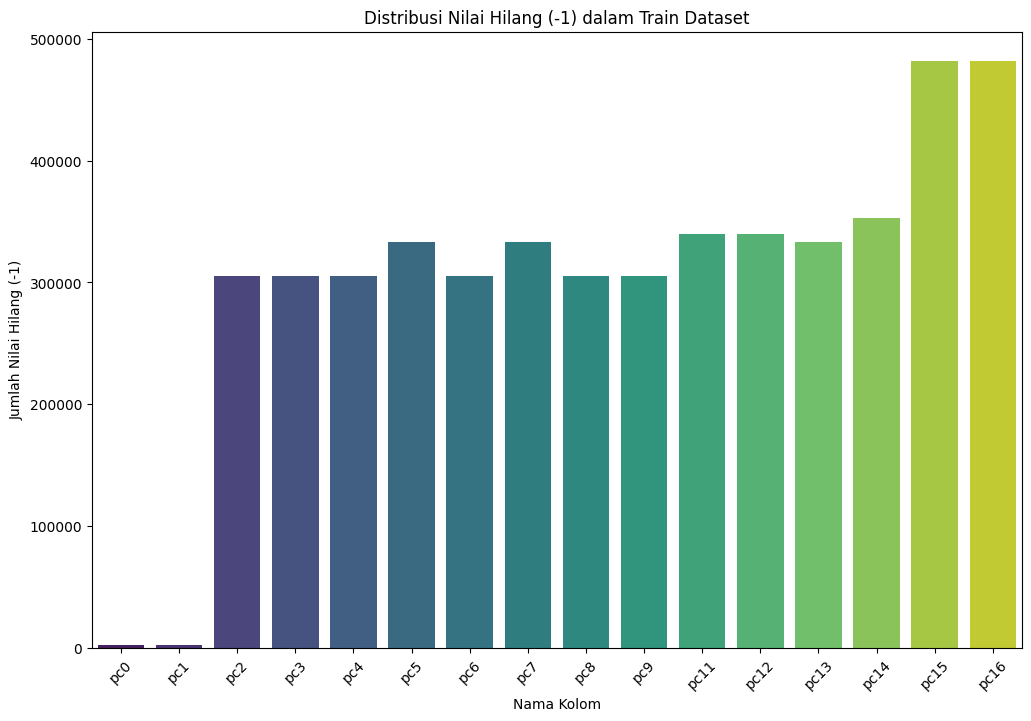

In [26]:
# Pengecekan nilai hilang pada Train dataset
print("Missing Values in Train Dataset:")
missing_values = (train_df == -1).sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
plt.title('Distribusi Nilai Hilang (-1) dalam Train Dataset')
plt.xlabel('Nama Kolom')
plt.ylabel('Jumlah Nilai Hilang (-1)')
plt.xticks(rotation=45)
plt.show()

- _Missing Values_ dari Dataset **_Non-Borrower_**

Missing Values in Non-Borrower User Dataset:


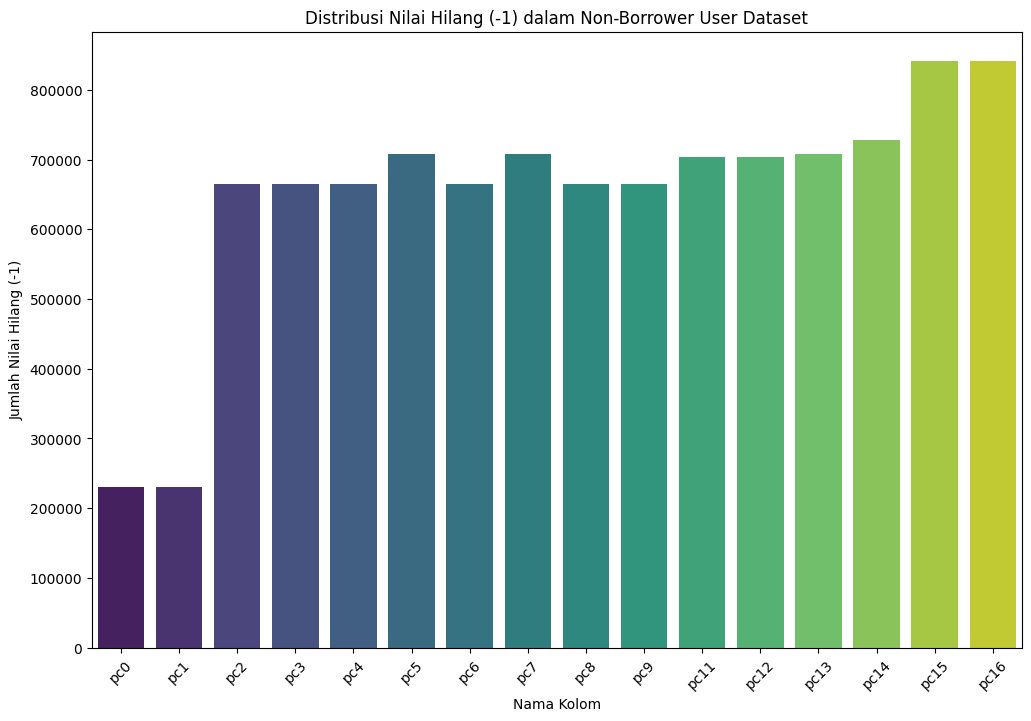

In [27]:
# Pengecekan nilai hilang pada Non-Borrower dataset
print("Missing Values in Non-Borrower User Dataset:")
missing_values = (non_borrower_user_df == -1).sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(12, 8))
sns.barplot(x=missing_values.index, y=missing_values.values, hue=missing_values.index, palette="viridis", legend=False)
plt.title('Distribusi Nilai Hilang (-1) dalam Non-Borrower User Dataset')
plt.xlabel('Nama Kolom')
plt.ylabel('Jumlah Nilai Hilang (-1)')
plt.xticks(rotation=45)
plt.show()

- Analisis _Missing Values_ dari Dataset **_Loan Activities_**

Missing Values in Loan Activities Dataset:


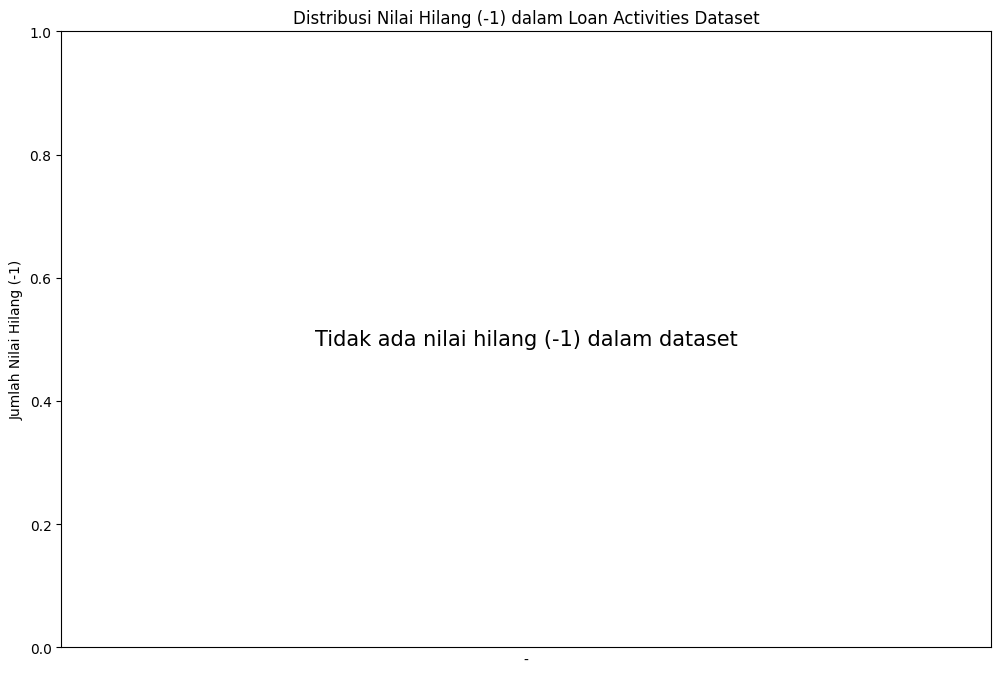

In [28]:
print("Missing Values in Loan Activities Dataset:")
missing_values = (loan_activities_df == -1).sum()
missing_values = missing_values[missing_values > 0]

plt.figure(figsize=(12, 8))

if not missing_values.empty:
    sns.barplot(x=missing_values.index, y=missing_values.values, palette="viridis")
    plt.title('Distribusi Nilai Hilang (-1) dalam Loan Activities Dataset')
    plt.xlabel('Nama Kolom')
    plt.ylabel('Jumlah Nilai Hilang (-1)')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'Tidak ada nilai hilang (-1) dalam dataset',
             horizontalalignment='center',
             verticalalignment='center',
             fontsize=15)
    plt.title('Distribusi Nilai Hilang (-1) dalam Loan Activities Dataset')
    plt.xlabel('-')
    plt.ylabel('Jumlah Nilai Hilang (-1)')
    plt.xticks([])
plt.show()

- Data cleaning menggunakan Imputer, Scaler, dan OneHotEncoder

In [29]:
# Preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Gabungkan kedua pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_cols),
        ('cat', categorical_pipeline, categorical_cols)
    ]
)

# Cleaning data
X = preprocessor.fit_transform(X)
X_test = preprocessor.transform(X_test)
X_non_borrower = preprocessor.transform(X_non_borrower)

# Konversi data ke array
X_dense = X.toarray()
X_test_dense = X_test.toarray()
X_non_borrower_dense = X_non_borrower.toarray()

[Back To Top](#Daftar-Isi)

<a name="#Data-Splitting"></a>
### Data Splitting

In [30]:
# Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_dense, y, test_size=0.1, random_state=0)

[Back To Top](#Daftar-Isi)

---
<a name="Exploratory-Data-Analysis"></a>
## Exploratory Data Analysis

<a name="Pemahaman-Format-Data"></a>
### Pemahaman Format Data


- Format Data dari Dataset **train.csv**

In [31]:
print("Train Dataset Preview:")
print(train_df.head())

Train Dataset Preview:
   user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  ...  \
0        3  1.0  1.0  0.275  0.255  0.927273  0.4  0.260  0.040  0.254  ...   
1        5  0.0  0.0  0.430  0.365  0.848837  0.4  1.253  0.210  1.235  ...   
2        9  1.0  3.0  1.315  0.825  0.627376  0.9  2.385  0.128  2.270  ...   
3       10  0.0  5.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000  ...   
4       17  1.0  1.0  0.235  0.160  0.680851  0.1  0.120  0.002  0.104  ...   

   prop_3    prop_4    prop_5  prop_6  prop_7  prop_8  prop_9  prop_10  \
0     NaN       NaN       NaN     NaN     NaN     NaN     NaN      NaN   
1     0.0  0.000000  0.500000     0.0     0.0     0.0     0.0      0.5   
2     0.0  0.666667  0.333333     0.0     0.0     0.0     0.0      0.0   
3     0.0  1.000000  0.000000     0.0     0.0     0.0     0.0      0.0   
4     0.0  1.000000  0.000000     0.0     0.0     0.0     0.0      0.0   

   prop_11  fraud_contact_count  
0      NaN             

- Format Data dari Dataset **test.csv**

In [32]:
print("\nTest Dataset Preview:")
print(test_df.head())


Test Dataset Preview:
   user_id  pc0  pc1    pc2    pc3       pc4  pc5    pc6    pc7    pc8  ...  \
0        4  1.0  2.0 -1.000 -1.000 -1.000000 -1.0 -1.000 -1.000 -1.000  ...   
1       13  1.0  5.0  0.445  0.420  0.943820  0.8  0.783  0.234  0.778  ...   
2       37  1.0  6.0  1.680  1.080  0.642857  0.6  1.167  0.046  1.007  ...   
3       61  0.0  3.0  1.505  0.875  0.581395  0.9  0.425  0.012  0.286  ...   
4       66  1.0  5.0  2.210  1.075  0.486425  1.0  1.349  0.087  1.015  ...   

   prop_3  prop_4  prop_5  prop_6  prop_7  prop_8  prop_9  prop_10  prop_11  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
1     0.0     0.0     0.5     0.0     0.0     0.0     0.0      0.0      0.0   
2     0.0     0.0     1.0     0.0     0.0     0.0     0.0      0.0      0.0   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
4     0.0     0.0     1.0     0.0     0.0     0.0     0.0      0.0      0.0   

   fraud_contact_count  
0 

- Format Data dari Dataset **loan_activities.csv**

In [33]:
print("\nLoan Activities Dataset Preview:")
print(loan_activities_df.head())


Loan Activities Dataset Preview:
   user_id  reference_contact  loan_type   ts  contact_is_fraud  loan_type_1  \
0  2223129             903716          1  671                 0          1.0   
1  1380939             484583          1   89                 0          1.0   
2  2724411            1185034          1  230                 0          1.0   
3  2401751            1369254          1  120                 0          1.0   
4  1982168              21797          1   57                 0          1.0   

   loan_type_2  loan_type_3  loan_type_4  loan_type_5  loan_type_6  \
0          0.0          0.0          0.0          0.0          0.0   
1          0.0          0.0          0.0          0.0          0.0   
2          0.0          0.0          0.0          0.0          0.0   
3          0.0          0.0          0.0          0.0          0.0   
4          0.0          0.0          0.0          0.0          0.0   

   loan_type_7  loan_type_8  loan_type_9  loan_type_10  loan_typ

- Format Data dari Dataset **non_borrower_user.csv**

In [34]:
print("\nNon-Borrower User Dataset Preview:")
print(non_borrower_user_df.head())


Non-Borrower User Dataset Preview:
   user_id  pc0  pc1   pc2    pc3       pc4  pc5    pc6   pc7    pc8  ...  \
0        0    1    5 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000  ...   
1        1    0    8  0.63  0.565  0.896825  0.6  2.298  0.21  2.284  ...   
2        2   -1   -1 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000  ...   
3        6    0    1 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000  ...   
4        7    1    6 -1.00 -1.000 -1.000000 -1.0 -1.000 -1.00 -1.000  ...   

   prop_3  prop_4  prop_5  prop_6  prop_7  prop_8  prop_9  prop_10  prop_11  \
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
1     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0      0.0   
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN      NaN   
4     0.0     0.0     0.0     0.0     0.0     0.0     0.0      0.0      1.0   

   fraud_contact_count  
0

[Back To Top](#Daftar-Isi)

### Dataset **Train**

- Statistik Deskriptif dari Dataset **_Train_**

In [35]:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik deskriptif untuk dataset training
print("Train Dataset Descriptive Statistics:")
display(train_df.describe())
numerical_columns = ['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'label']

Train Dataset Descriptive Statistics:


user_id            pc0            pc1            pc2  \
count  8.578990e+05  857899.000000  857899.000000  857899.000000   
mean   1.851235e+06       0.746870       3.709053       0.545364   
std    1.069052e+06       0.439532       1.934880       1.941448   
min    3.000000e+00      -1.000000      -1.000000      -1.000000   
25%    9.251405e+05       0.000000       2.000000      -1.000000   
50%    1.851614e+06       1.000000       4.000000       0.365000   
75%    2.778174e+06       1.000000       5.000000       1.150000   
max    3.700548e+06       1.000000       8.000000     111.815000   

                 pc3            pc4            pc5            pc6  \
count  857899.000000  857899.000000  857899.000000  857899.000000   
mean        0.391718       0.175067       0.315356       0.961431   
std         1.766663       0.880198       1.790893       2.766861   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%         0.295000       0.738007       0.300000       0.312000   
75%         0.915000       0.884120       0.900000       1.501000   
max       111.475000       1.000000     456.300000      64.119000   

                 pc7           pc8  ...         prop_3         prop_4  \
count  857899.000000  857899.00000  ...  675432.000000  675432.000000   
mean       -0.245161       0.91576  ...       0.034378       0.221439   
std         0.696857       2.71027  ...       0.142125       0.331405   
min        -1.000000      -1.00000  ...       0.000000       0.000000   
25%        -1.000000      -1.00000  ...       0.000000       0.000000   
50%         0.011000       0.28700  ...       0.000000       0.000000   
75%         0.114000       1.43400  ...       0.000000       0.500000   
max        12.338000      63.41600  ...       1.000000       1.000000   

              prop_5         prop_6         prop_7         prop_8  \
count  675432.000000  675432.000000  675432.000000  675432.000000   
mean        0.374416       0.148300       0.001535       0.014595   
std         0.388247       0.280936       0.034527       0.089068   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.333333       0.000000       0.000000       0.000000   
75%         0.666667       0.250000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              prop_9        prop_10        prop_11  fraud_contact_count  
count  675432.000000  675432.000000  675432.000000        675432.000000  
mean        0.025302       0.048661       0.018584             0.005411  
std         0.133612       0.180061       0.112713             0.073685  
min         0.000000       0.000000       0.000000             0.000000  
25%         0.000000       0.000000       0.000000             0.000000  
50%         0.000000       0.000000       0.000000             0.000000  
75%         0.000000       0.000000       0.000000             0.000000  
max         1.000000       1.000000       1.000000             2.000000  

[8 rows x 48 columns]

- Analisis Distribusi Data dari Dataset **_Train_**

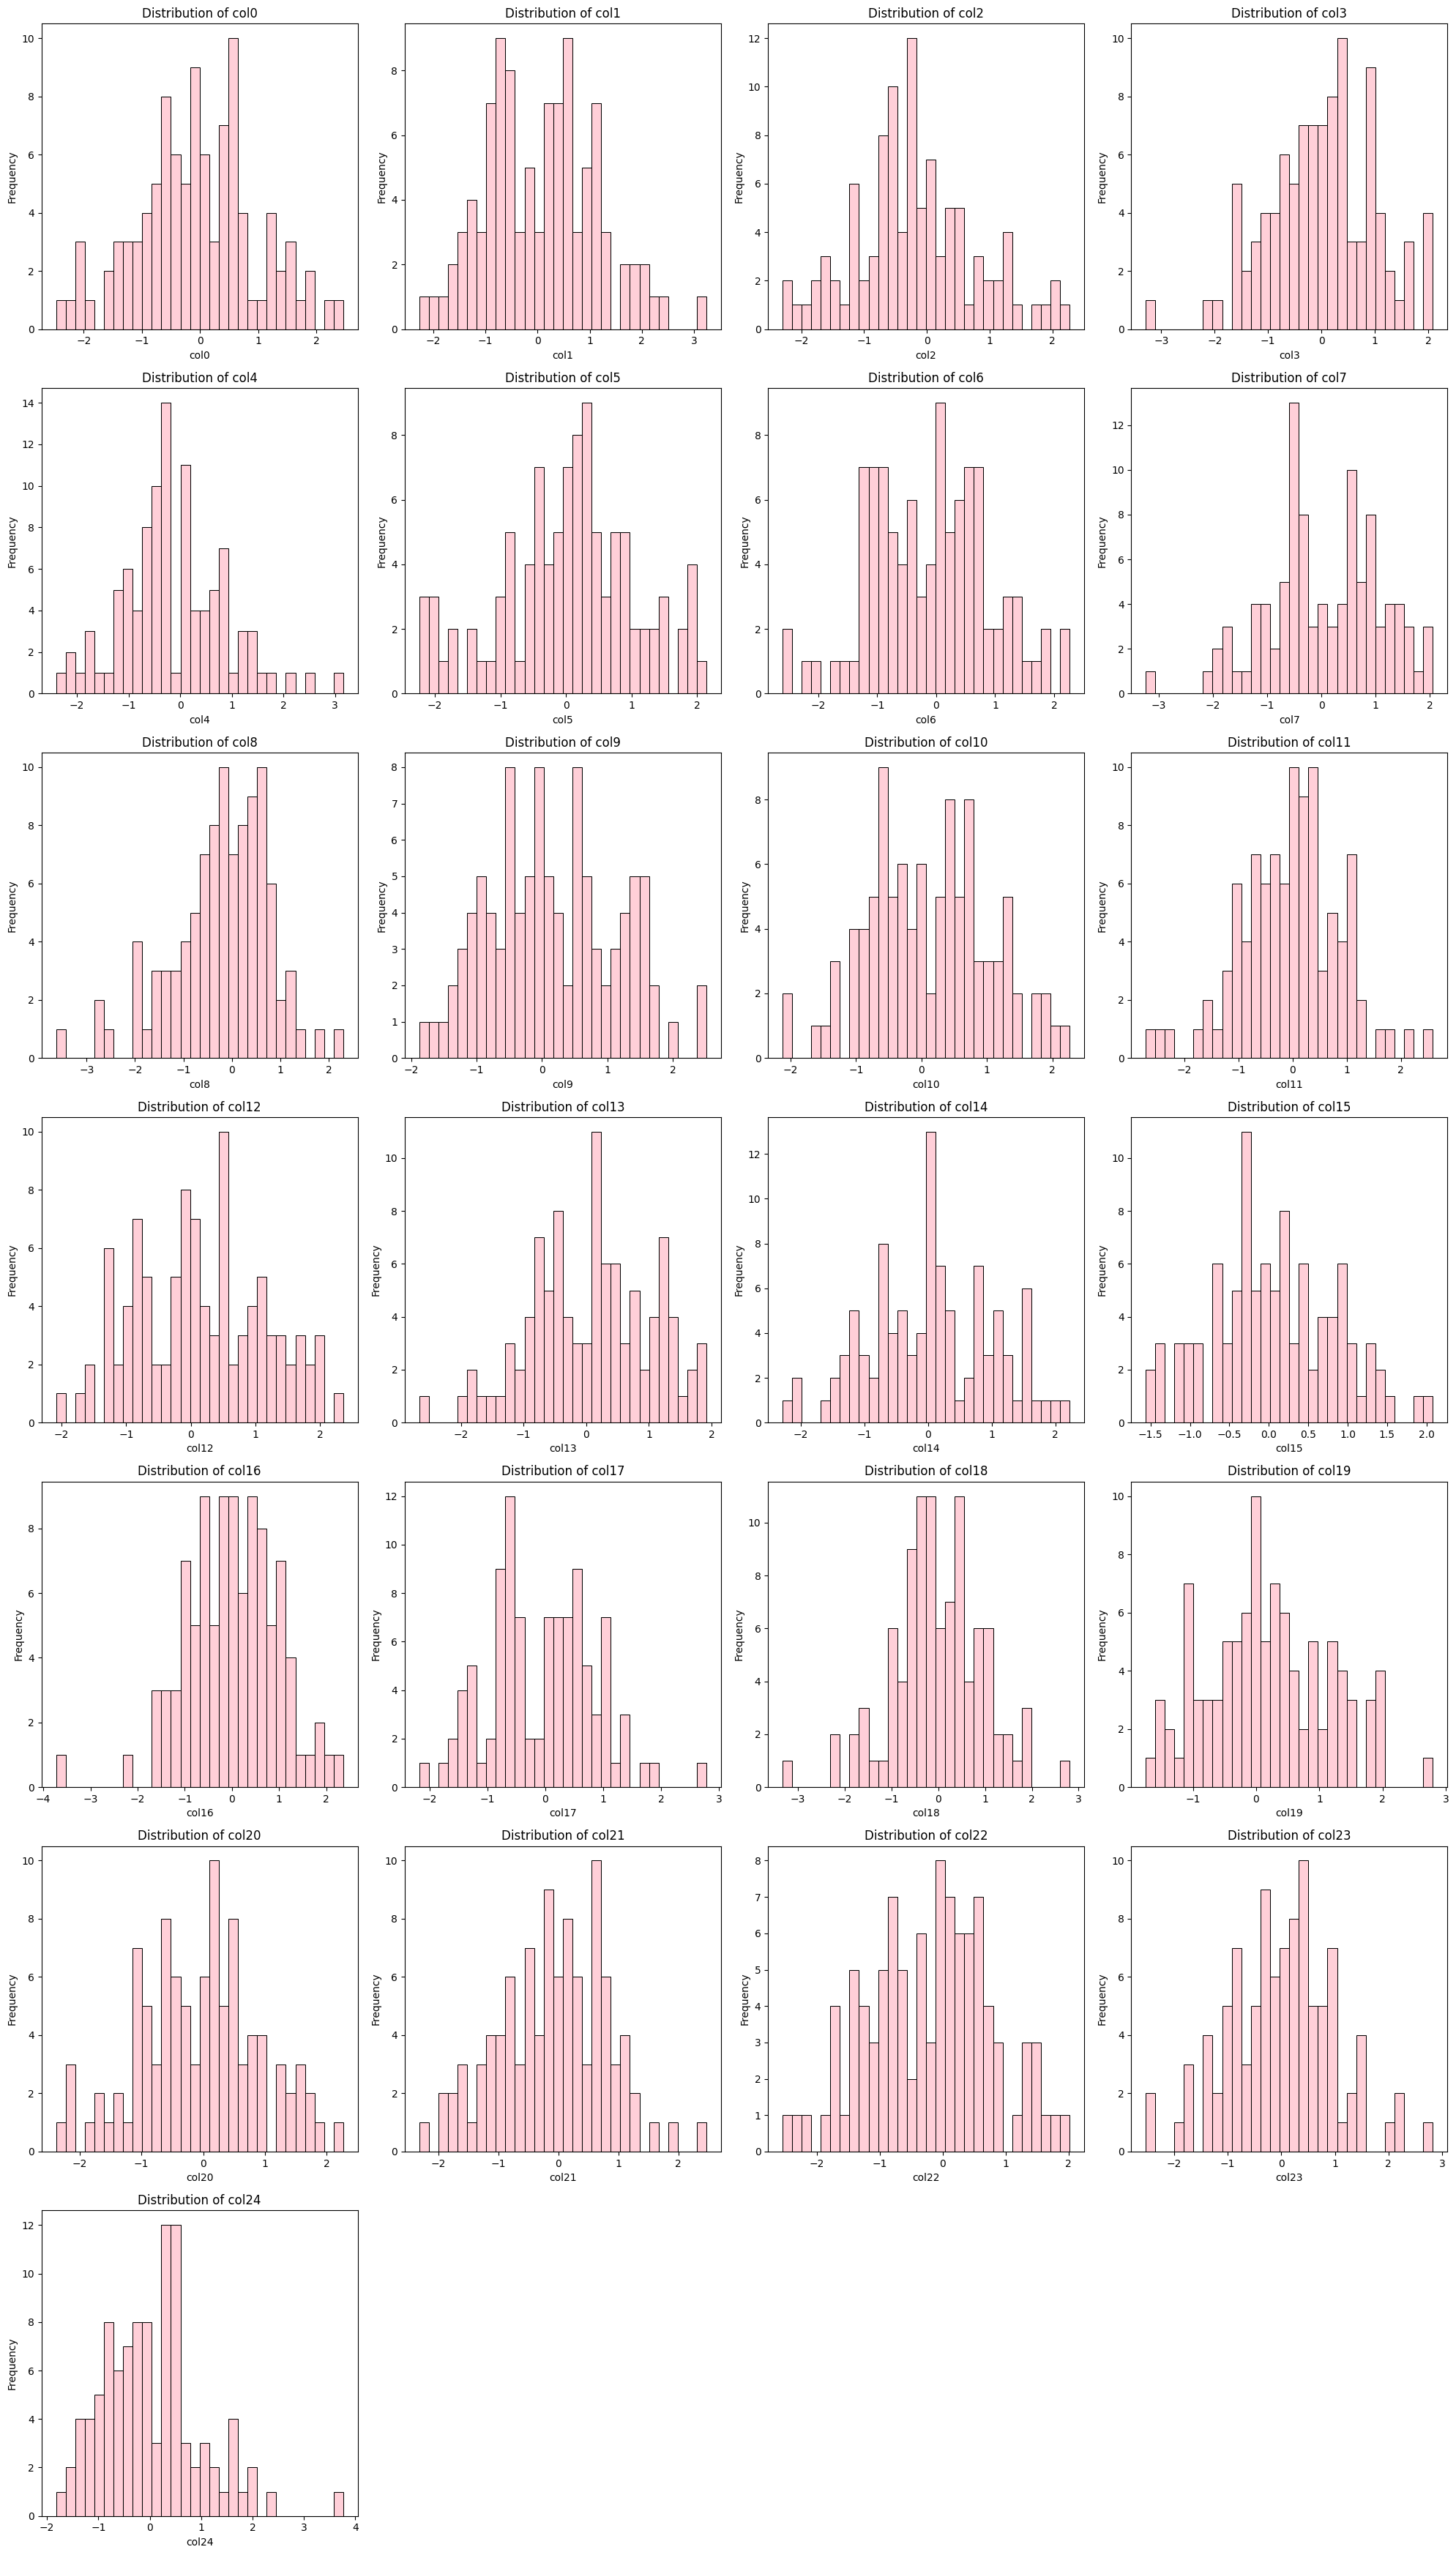

In [36]:
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

# Sample train_df for testing
import pandas as pd
import numpy as np

# Creating a sample DataFrame with more than 20 numerical columns
train_df = pd.DataFrame(np.random.randn(100, 25), columns=[f'col{i}' for i in range(25)])

numerical_columns = train_df.select_dtypes(include=['float64', 'int64']).columns

# Ignore specific warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

num_columns = len(numerical_columns)
num_rows = (num_columns // 4) + 1 if num_columns % 4 != 0 else num_columns // 4

plt.figure(figsize=(20, num_rows * 5))
for index, column in enumerate(numerical_columns):
    plt.subplot(num_rows, 4, index + 1)
    sns.histplot(train_df[column], bins=30, kde=False, color='pink')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Analisis Korelasi Variabel Data dari Dataset **_Train_**

Correlation Matrix:
           col0      col1      col2      col3      col4      col5      col6  \
col0   1.000000  0.016271  0.011024  0.082594 -0.091197 -0.223511  0.066056   
col1   0.016271  1.000000  0.177513 -0.116716  0.078492 -0.157963 -0.011965   
col2   0.011024  0.177513  1.000000 -0.203904 -0.123288 -0.140035  0.109405   
col3   0.082594 -0.116716 -0.203904  1.000000 -0.029097 -0.034060 -0.121450   
col4  -0.091197  0.078492 -0.123288 -0.029097  1.000000  0.167193  0.085107   
col5  -0.223511 -0.157963 -0.140035 -0.034060  0.167193  1.000000  0.025179   
col6   0.066056 -0.011965  0.109405 -0.121450  0.085107  0.025179  1.000000   
col7   0.010205  0.012927  0.143377  0.080376 -0.083773  0.032303  0.098813   
col8  -0.033081  0.056665 -0.207133 -0.111142 -0.008676  0.101403  0.047397   
col9  -0.064915 -0.055768  0.021109 -0.125138  0.004827 -0.061212 -0.079043   
col10  0.008525  0.218571  0.023494  0.077381  0.119662  0.019044  0.150340   
col11 -0.033843 -0.128929  0.058

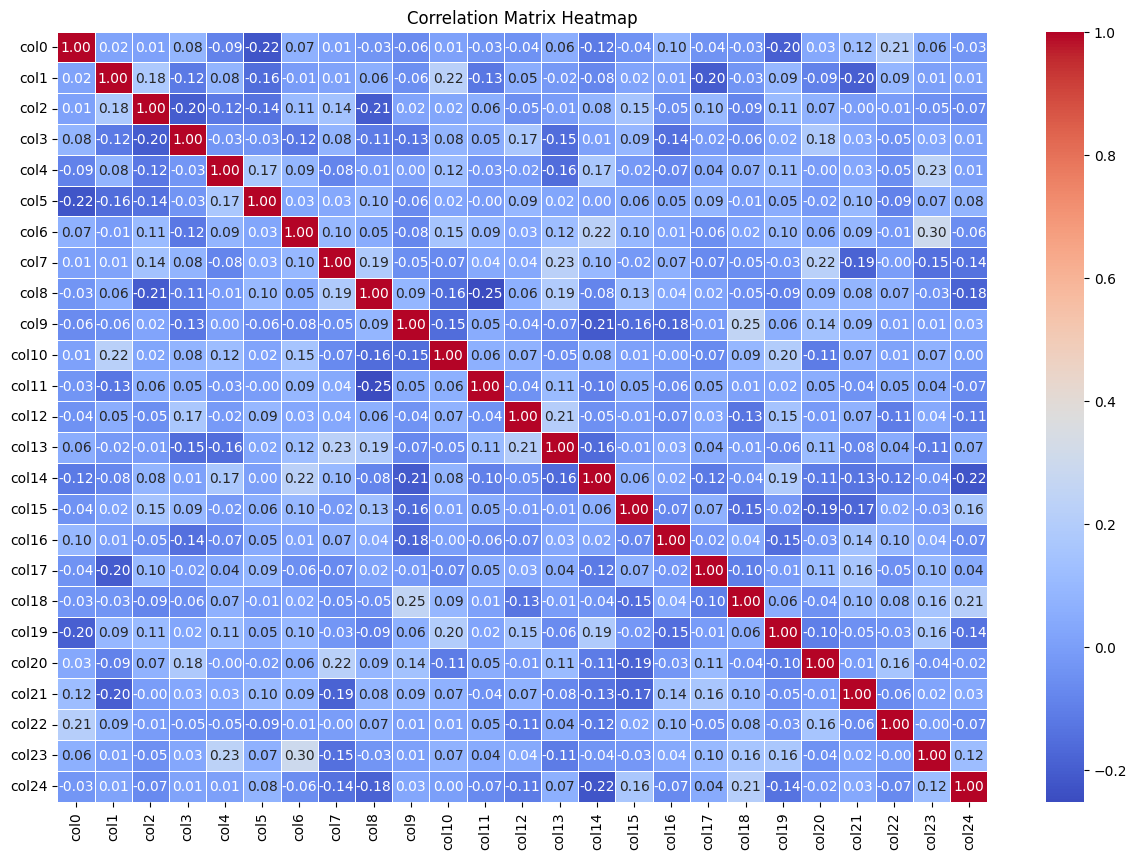

In [37]:
# Menghitung matriks korelasi
correlation_matrix = train_df.corr()

# Menampilkan matriks korelasi
print("Correlation Matrix:")
print(correlation_matrix)

# Visualisasi matriks korelasi menggunakan heatmap dari seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

[Back To Top](#Daftar-Isi)

### Dataset **Test**

- Statistik Deskriptif dari Dataset **_Test_**

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik deskriptif untuk dataset training
print("Test Dataset Descriptive Statistics:")
display(test_df.describe())
numerical_columns = ['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'label']

Test Dataset Descriptive Statistics:


user_id            pc0            pc1            pc2  \
count  3.677020e+05  367702.000000  367702.000000  367702.000000   
mean   1.846733e+06       0.746082       3.707519       0.548174   
std    1.068780e+06       0.439969       1.935365       1.948030   
min    4.000000e+00      -1.000000      -1.000000      -1.000000   
25%    9.194445e+05       0.000000       2.000000      -1.000000   
50%    1.844812e+06       1.000000       4.000000       0.360000   
75%    2.773638e+06       1.000000       5.000000       1.150000   
max    3.700544e+06       1.000000       8.000000      90.390000   

                 pc3            pc4            pc5            pc6  \
count  367702.000000  367702.000000  367702.000000  367702.000000   
mean        0.393795       0.172392       0.317049       0.966813   
std         1.772834       0.880674       1.738704       2.791356   
min        -1.000000      -1.000000      -1.000000      -1.000000   
25%        -1.000000      -1.000000      -1.000000      -1.000000   
50%         0.290000       0.736264       0.300000       0.309000   
75%         0.920000       0.883721       0.900000       1.505000   
max        90.160000       1.000000     120.200000      68.646000   

                 pc7            pc8  ...         prop_3         prop_4  \
count  367702.000000  367702.000000  ...  289408.000000  289408.000000   
mean       -0.246681       0.920817  ...       0.034512       0.221347   
std         0.699443       2.734626  ...       0.141924       0.331124   
min        -1.000000      -1.000000  ...       0.000000       0.000000   
25%        -1.000000      -1.000000  ...       0.000000       0.000000   
50%         0.011000       0.284000  ...       0.000000       0.000000   
75%         0.114000       1.437000  ...       0.000000       0.500000   
max        12.679000      68.027000  ...       1.000000       1.000000   

              prop_5         prop_6         prop_7         prop_8  \
count  289408.000000  289408.000000  289408.000000  289408.000000   
mean        0.374920       0.148561       0.001571       0.014293   
std         0.388803       0.280548       0.034931       0.087562   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.333333       0.000000       0.000000       0.000000   
75%         0.666667       0.250000       0.000000       0.000000   
max         1.000000       1.000000       1.000000       1.000000   

              prop_9        prop_10        prop_11  fraud_contact_count  
count  289408.000000  289408.000000  289408.000000        289408.000000  
mean        0.025246       0.048430       0.018532             0.005211  
std         0.133384       0.179805       0.112076             0.072332  
min         0.000000       0.000000       0.000000             0.000000  
25%         0.000000       0.000000       0.000000             0.000000  
50%         0.000000       0.000000       0.000000             0.000000  
75%         0.000000       0.000000       0.000000             0.000000  
max         1.000000       1.000000       1.000000             2.000000  

[8 rows x 47 columns]

- Analisis Distribusi Data dari Dataset **_Test_**

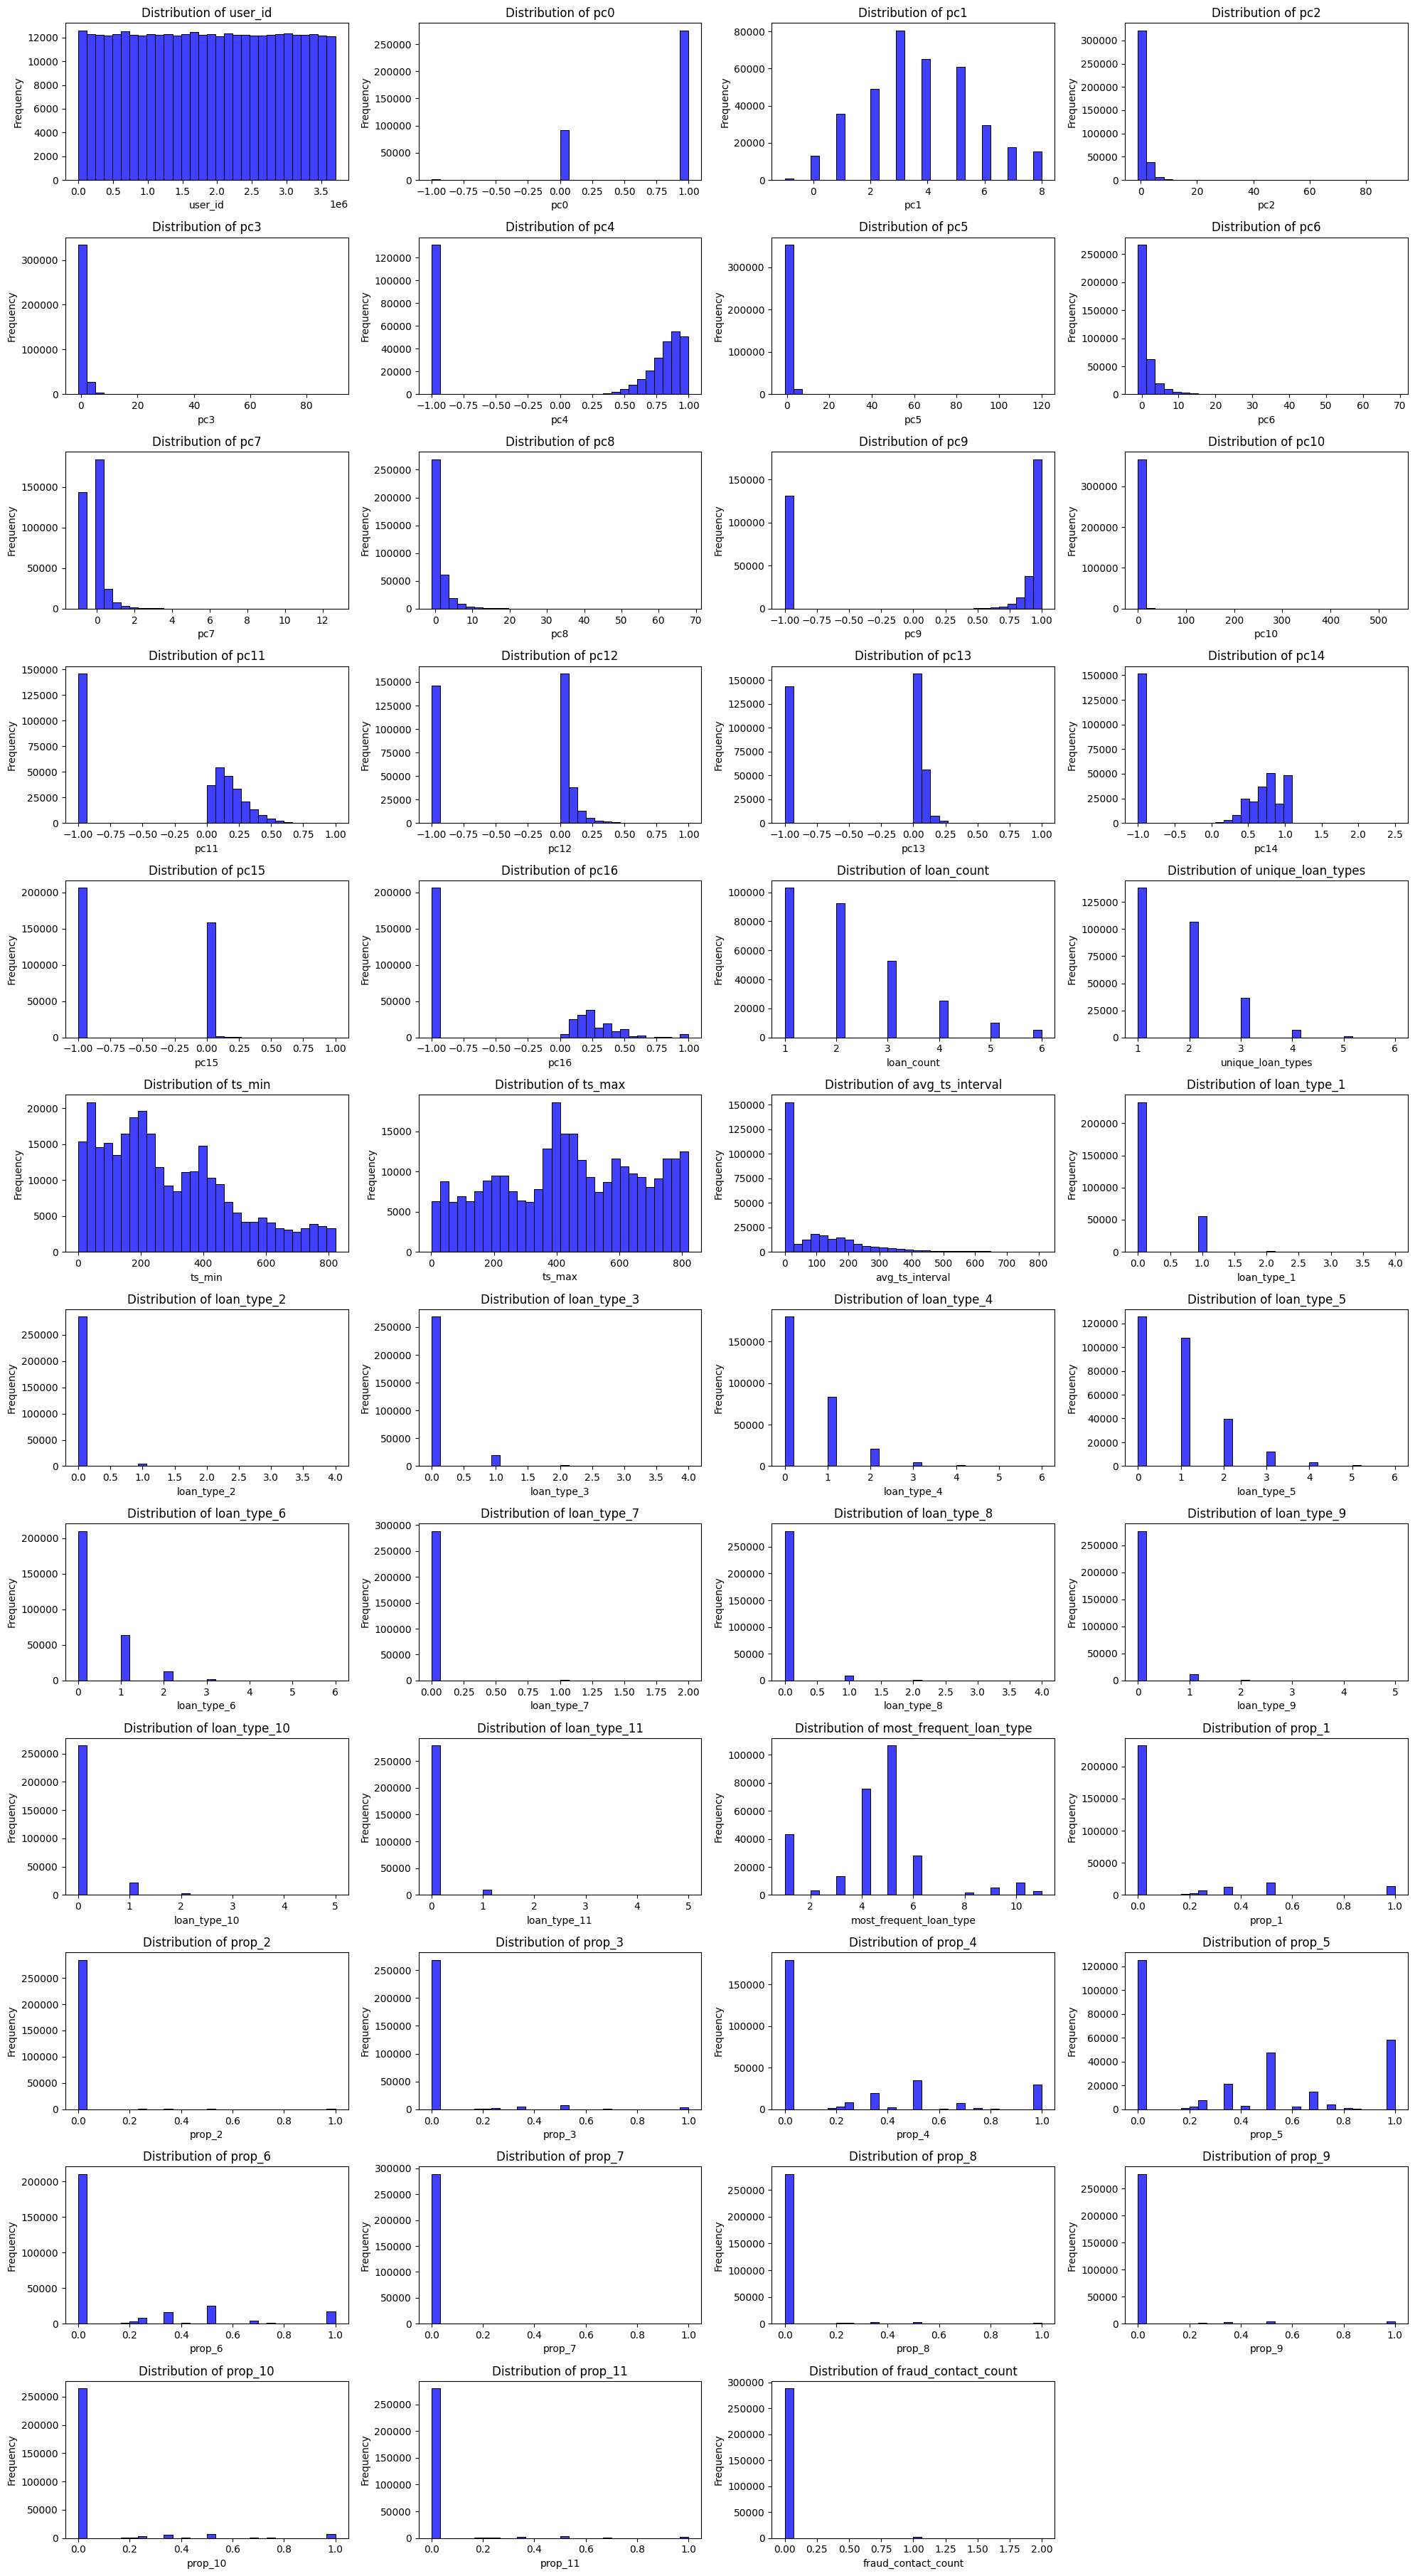

In [62]:
import warnings
# Ignore specific warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

numerical_columns = test_df.select_dtypes(include=['float64', 'int64']).columns

plt.figure(figsize=(20, 60))
for index, column in enumerate(numerical_columns):
    plt.subplot(20, 4, index + 1)
    sns.histplot(test_df[column], bins=30, kde=False, color='blue')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')


plt.tight_layout()
plt.show()

- Analisis Korelasi Variabel Data dari Dataset **_Test_**

Correlation Matrix:
                          user_id       pc0           pc1       pc2       pc3  \
user_id                  1.000000  0.000380  6.228349e-04  0.001901  0.002077   
pc0                      0.000380  1.000000 -5.032883e-02  0.046274  0.042554   
pc1                      0.000623 -0.050329  1.000000e+00  0.106558  0.092362   
pc2                      0.001901  0.046274  1.065584e-01  1.000000  0.992111   
pc3                      0.002077  0.042554  9.236198e-02  0.992111  1.000000   
pc4                      0.000539  0.008457  1.627588e-02  0.590819  0.594118   
pc5                      0.002943  0.042748  9.453741e-02  0.852311  0.858969   
pc6                      0.002087  0.032831  1.754232e-01  0.755122  0.735735   
pc7                      0.001238  0.004772  9.057190e-02  0.647644  0.633301   
pc8                      0.002138  0.032712  1.735447e-01  0.748807  0.731951   
pc9                      0.000426  0.010564  2.295667e-02  0.593871  0.590606   
pc10    

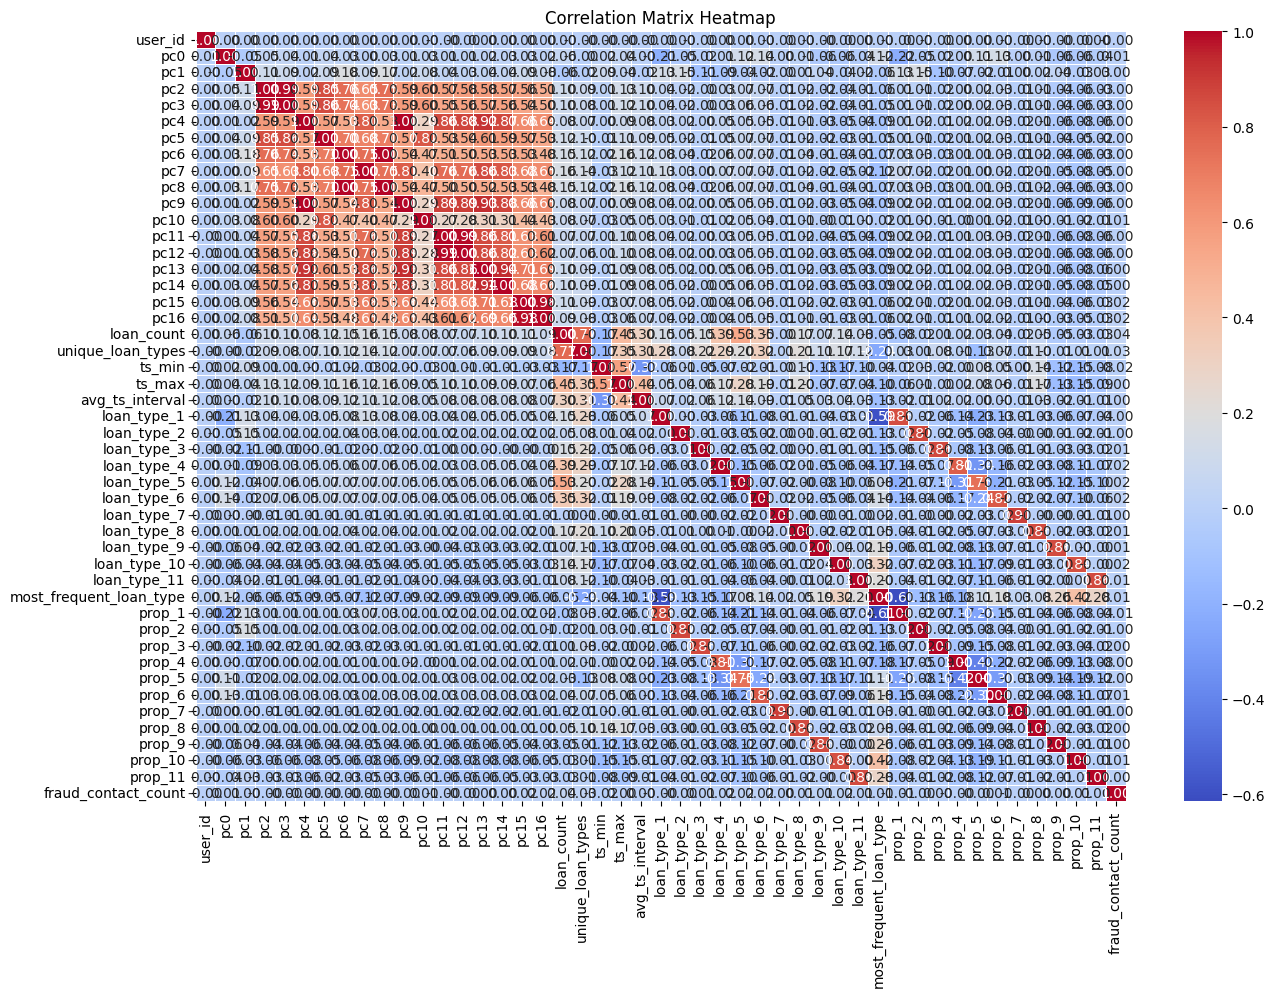

In [40]:
# Menghitung matriks korelasi
correlation_matrix = test_df.corr()

# Menampilkan matriks korelasi
print("Correlation Matrix:")
print(correlation_matrix)

# Visualisasi matriks korelasi menggunakan heatmap dari seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

[Back To Top](#Daftar-Isi)

### Dataset **Non-Borrower**

- Statistik Deskriptif dari Dataset **_Non-Borrower_**

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Statistik deskriptif untuk dataset training
print("Non-Borrower User Dataset Descriptive Statistics:")
display(non_borrower_user_df.describe())
numerical_columns = ['pc0', 'pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16']

Non-Borrower User Dataset Descriptive Statistics:


user_id           pc0           pc1           pc2           pc3  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean   7.845509e+05  3.887829e-01  2.764622e+00 -4.025661e-01 -4.321563e-01   
std    4.526281e+05  8.221746e-01  2.870280e+00  9.388054e-01  8.878405e-01   
min    0.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%    3.925625e+05  0.000000e+00  0.000000e+00 -1.000000e+00 -1.000000e+00   
50%    7.851340e+05  1.000000e+00  3.000000e+00 -1.000000e+00 -1.000000e+00   
75%    1.176676e+06  1.000000e+00  5.000000e+00  2.500000e-01  2.150000e-01   
max    1.568298e+06  1.000000e+00  8.000000e+00  5.176500e+01  5.091500e+01   

                pc4           pc5           pc6           pc7           pc8  \
count  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06  1.048575e+06   
mean  -3.165213e-01 -4.604148e-01 -3.464219e-01 -6.442732e-01 -3.551684e-01   
std    9.028309e-01  9.240246e-01  1.042326e+00  5.216804e-01  1.027156e+00   
min   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
25%   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
50%   -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00 -1.000000e+00   
75%    8.413886e-01  2.000000e-01  2.330000e-01  7.000000e-03  2.200000e-01   
max    1.000000e+00  9.180000e+01  3.430200e+01  7.132000e+00  3.406400e+01   

       ...         prop_3         prop_4         prop_5         prop_6  \
count  ...  518814.000000  518814.000000  518814.000000  518814.000000   
mean   ...       0.032937       0.193008       0.354727       0.139166   
std    ...       0.148574       0.335964       0.409919       0.291760   
min    ...       0.000000       0.000000       0.000000       0.000000   
25%    ...       0.000000       0.000000       0.000000       0.000000   
50%    ...       0.000000       0.000000       0.000000       0.000000   
75%    ...       0.000000       0.333333       0.666667       0.000000   
max    ...       1.000000       1.000000       1.000000       1.000000   

              prop_7         prop_8        prop_9        prop_10  \
count  518814.000000  518814.000000  518814.00000  518814.000000   
mean        0.008219       0.019652       0.04362       0.082383   
std         0.083740       0.114250       0.18740       0.248203   
min         0.000000       0.000000       0.00000       0.000000   
25%         0.000000       0.000000       0.00000       0.000000   
50%         0.000000       0.000000       0.00000       0.000000   
75%         0.000000       0.000000       0.00000       0.000000   
max         1.000000       1.000000       1.00000       1.000000   

             prop_11  fraud_contact_count  
count  518814.000000        518814.000000  
mean        0.026073             0.006561  
std         0.142341             0.081139  
min         0.000000             0.000000  
25%         0.000000             0.000000  
50%         0.000000             0.000000  
75%         0.000000             0.000000  
max         1.000000             2.000000  

[8 rows x 47 columns]

- Analisis Distribusi Data dari Dataset **_Non-Borrower_**

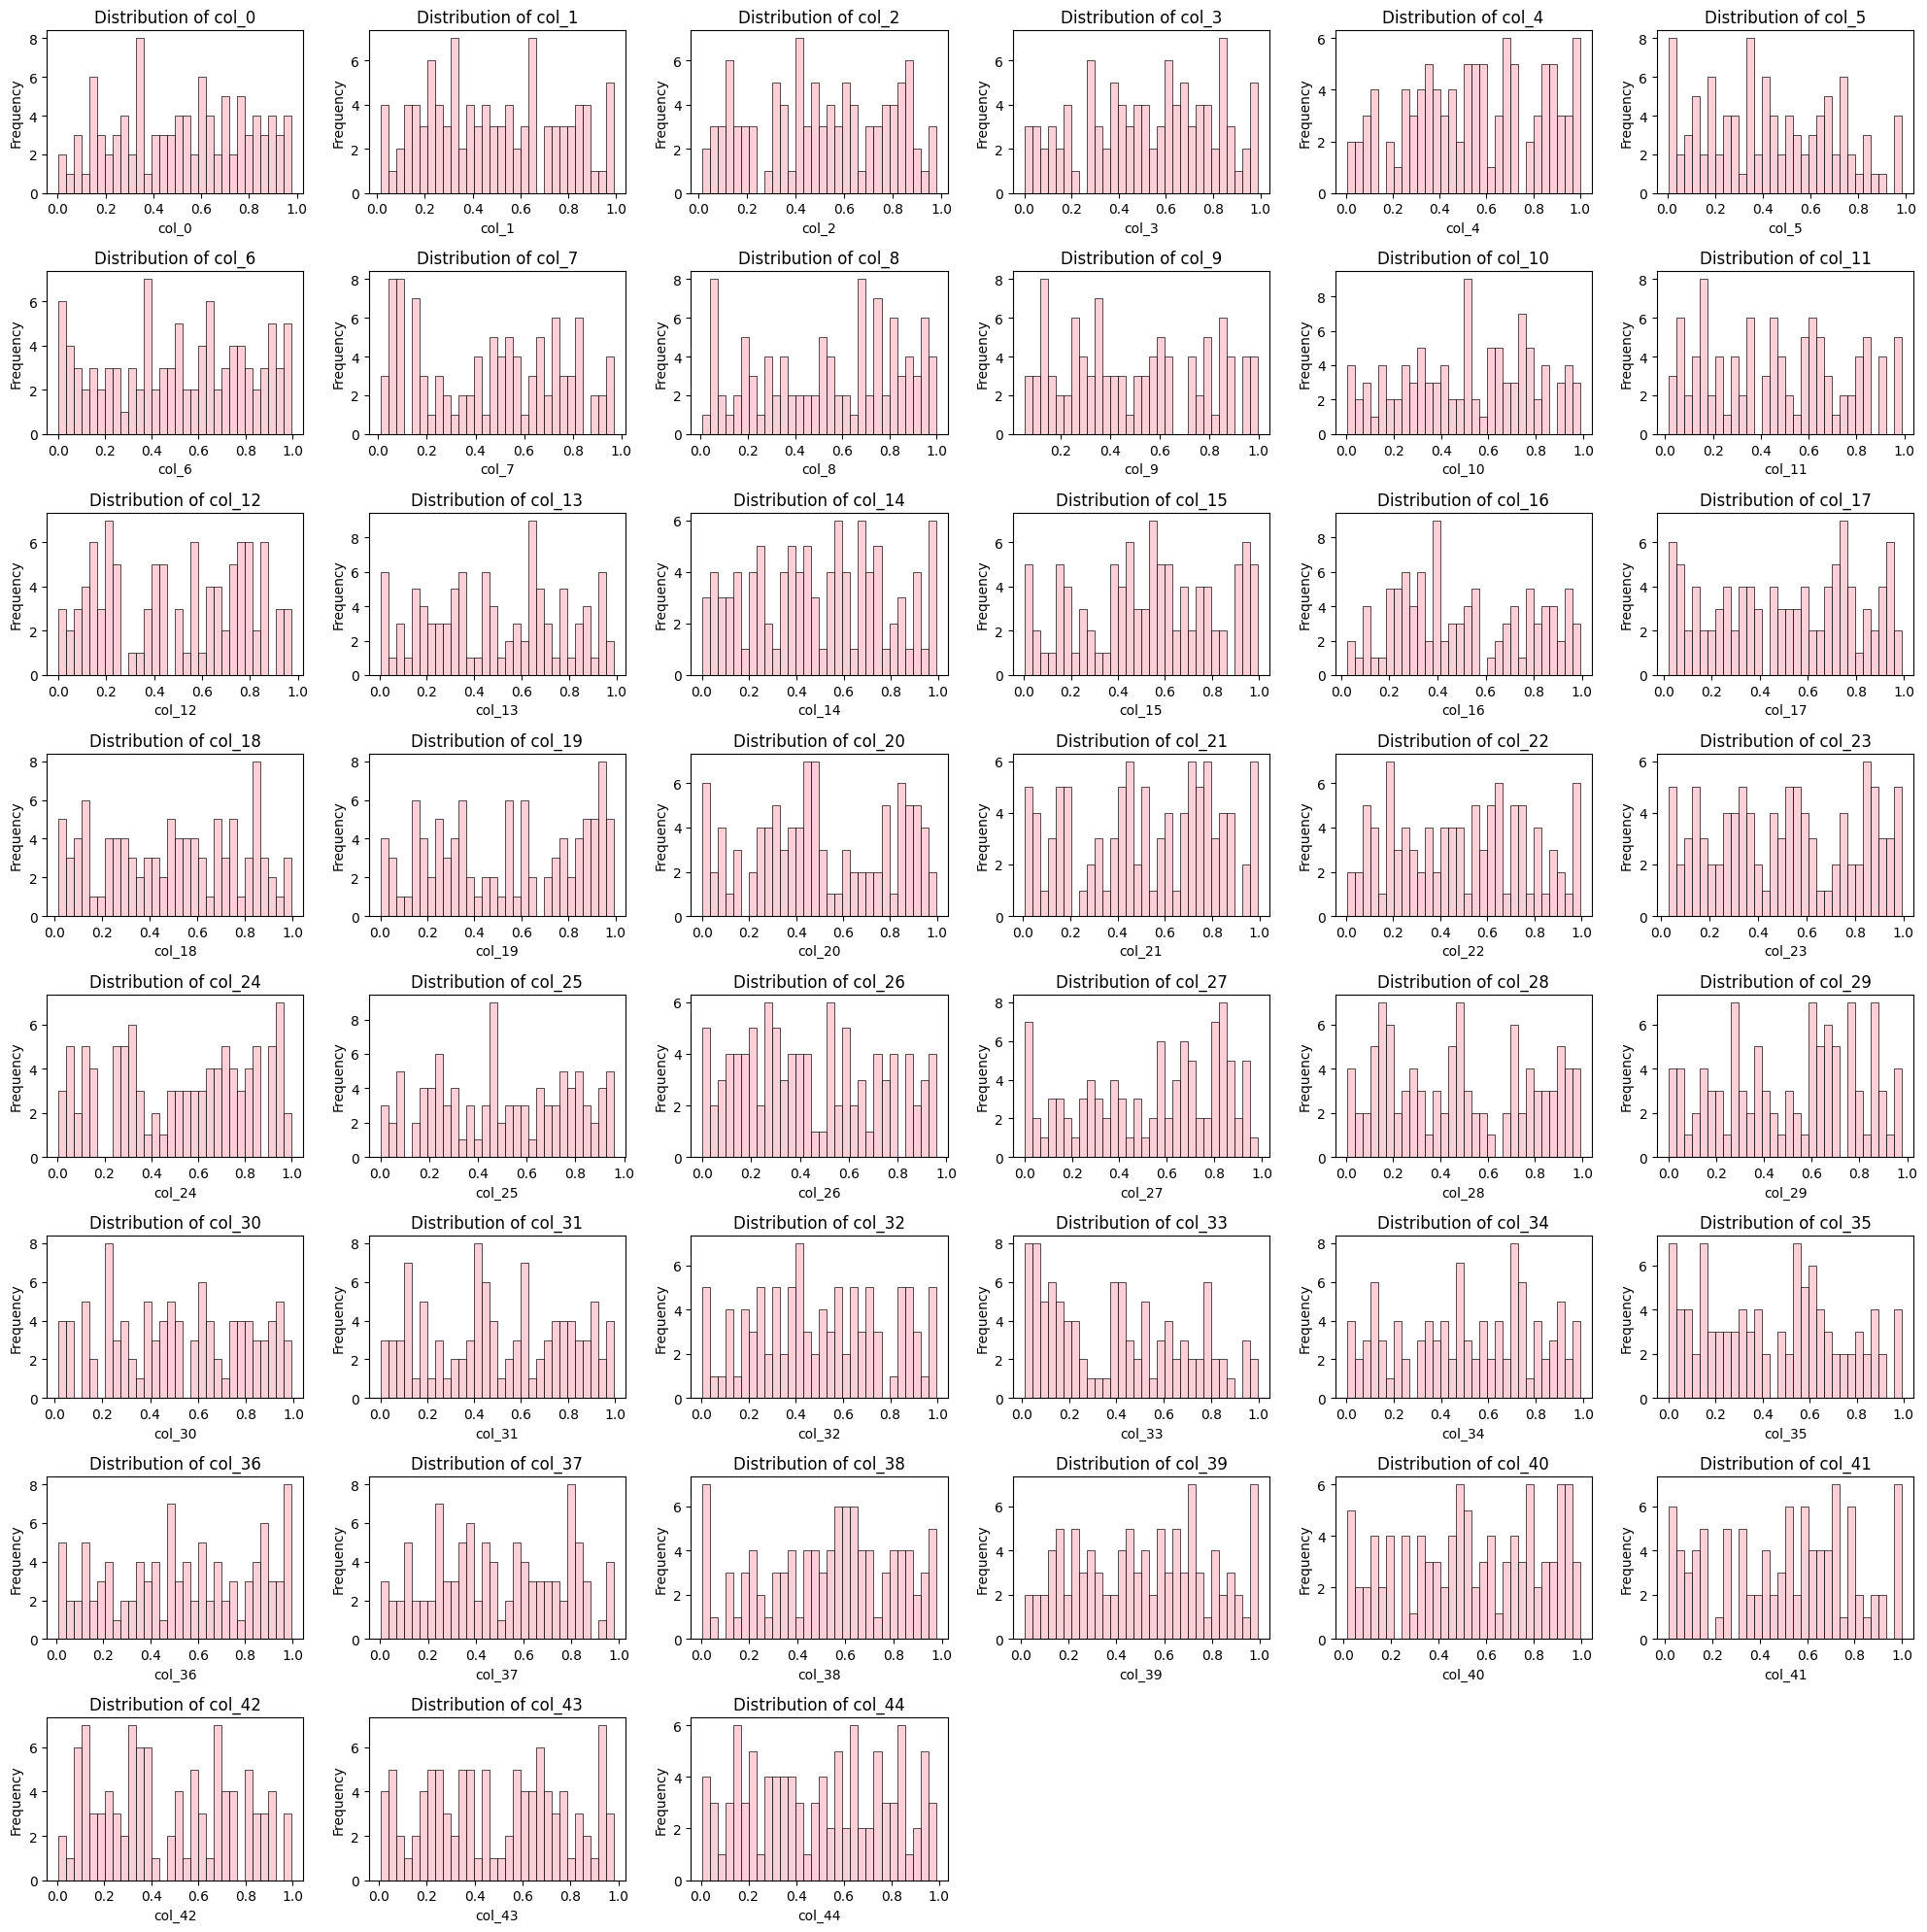

In [42]:
import warnings
# Ignore warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

non_borrower_user_df = pd.DataFrame(np.random.rand(100, 45), columns=[f'col_{i}' for i in range(45)])
numerical_columns = non_borrower_user_df.select_dtypes(include=['float64', 'int64']).columns

n_cols = 6
n_rows = (len(numerical_columns) + n_cols - 1) // n_cols

plt.figure(figsize=(20, n_rows * 2.5))
for index, column in enumerate(numerical_columns):
    plt.subplot(n_rows, n_cols, index + 1)
    sns.histplot(non_borrower_user_df[column], bins=30, kde=False, color='pink')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Analisis Korelasi Variabel Data dari Dataset **_Non-Borrower_**

Correlation Matrix:
           col_0     col_1     col_2     col_3     col_4     col_5     col_6  \
col_0   1.000000 -0.184534 -0.076769 -0.085701 -0.041252 -0.128497  0.017345   
col_1  -0.184534  1.000000 -0.064682  0.025264  0.064717  0.028710  0.055241   
col_2  -0.076769 -0.064682  1.000000  0.054969  0.149493  0.059950  0.113280   
col_3  -0.085701  0.025264  0.054969  1.000000 -0.005321 -0.039060 -0.080114   
col_4  -0.041252  0.064717  0.149493 -0.005321  1.000000 -0.048919  0.110794   
col_5  -0.128497  0.028710  0.059950 -0.039060 -0.048919  1.000000  0.041111   
col_6   0.017345  0.055241  0.113280 -0.080114  0.110794  0.041111  1.000000   
col_7  -0.059881 -0.064736 -0.010853 -0.012719  0.004560  0.035267  0.022010   
col_8  -0.046896 -0.082305  0.121284 -0.031123  0.094409 -0.122442 -0.049289   
col_9  -0.008309 -0.072265 -0.100945  0.158703 -0.024228 -0.075405 -0.095355   
col_10 -0.169836  0.070541  0.112689  0.115605  0.023236 -0.124865 -0.069105   
col_11 -0.060857  0.

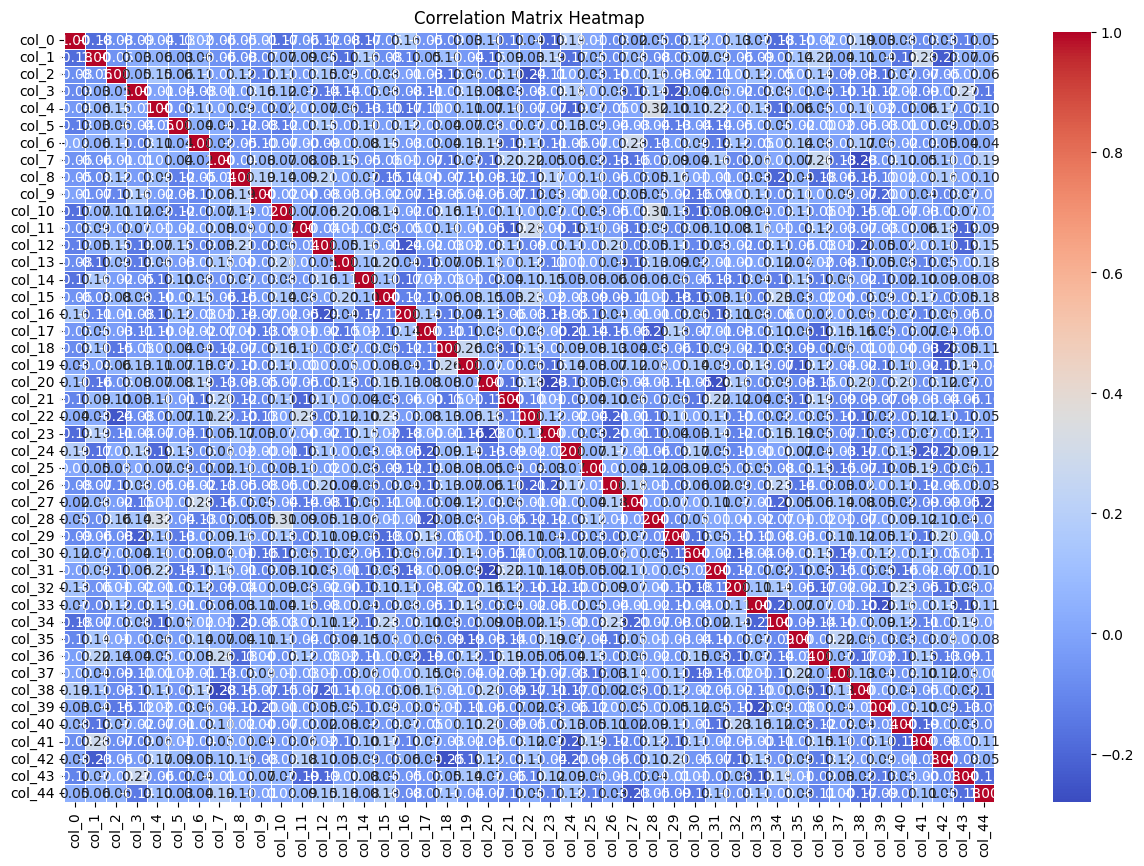

In [43]:
# Menghitung matriks korelasi
correlation_matrix = non_borrower_user_df.corr()

# Menampilkan matriks korelasi
print("Correlation Matrix:")
print(correlation_matrix)

# Visualisasi matriks korelasi menggunakan heatmap dari seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

[Back To Top](#Daftar-Isi)

### Dataset **Loan Activities**


- Statistik Deskriptif dari Dataset **_Loan Activities_**

In [44]:
# Statistik deskriptif untuk dataset training
print("Loan Activities Dataset Descriptive Statistics:")
display(loan_activities_df.describe())
numerical_columns = ['user_id', 'reference_contact',  'loan_type', 'ts']

Loan Activities Dataset Descriptive Statistics:


user_id  reference_contact     loan_type            ts  \
count  4.300999e+06       4.300999e+06  4.300999e+06  4.300999e+06   
mean   1.850565e+06       1.849301e+06  5.104953e+00  4.093275e+02   
std    1.068463e+06       1.068566e+06  2.205495e+00  2.222010e+02   
min    1.000000e+00       0.000000e+00  1.000000e+00  1.000000e+00   
25%    9.249810e+05       9.229035e+05  4.000000e+00  2.260000e+02   
50%    1.849778e+06       1.849514e+06  5.000000e+00  4.120000e+02   
75%    2.776584e+06       2.775052e+06  6.000000e+00  5.820000e+02   
max    3.700548e+06       3.700549e+06  1.100000e+01  8.210000e+02   

       contact_is_fraud   loan_type_1   loan_type_2   loan_type_3  \
count      4.300999e+06  4.300999e+06  4.300999e+06  4.300999e+06   
mean       3.082772e-03  8.437668e-02  1.195559e-02  3.487027e-02   
std        5.543708e-02  2.779519e-01  1.086861e-01  1.834512e-01   
min        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%        0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max        1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

        loan_type_4   loan_type_5   loan_type_6   loan_type_7   loan_type_8  \
count  4.300999e+06  4.300999e+06  4.300999e+06  4.300999e+06  4.300999e+06   
mean   2.119635e-01  3.729873e-01  1.500556e-01  3.692630e-03  1.960893e-02   
std    4.086992e-01  4.835988e-01  3.571260e-01  6.065473e-02  1.386522e-01   
min    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
25%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
50%    0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
75%    0.000000e+00  1.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00   
max    1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   

        loan_type_9  loan_type_10  loan_type_11  
count  4.300999e+06  4.300999e+06  4.300999e+06  
mean   2.906906e-02  6.103582e-02  2.038457e-02  
std    1.680002e-01  2.393960e-01  1.413119e-01  
min    0.000000e+00  0.000000e+00  0.000000e+00  
25%    0.000000e+00  0.000000e+00  0.000000e+00  
50%    0.000000e+00  0.000000e+00  0.000000e+00  
75%    0.000000e+00  0.000000e+00  0.000000e+00  
max    1.000000e+00  1.000000e+00  1.000000e+00

- Analisis Distribusi Data dari Dataset **_Loan Activities_**

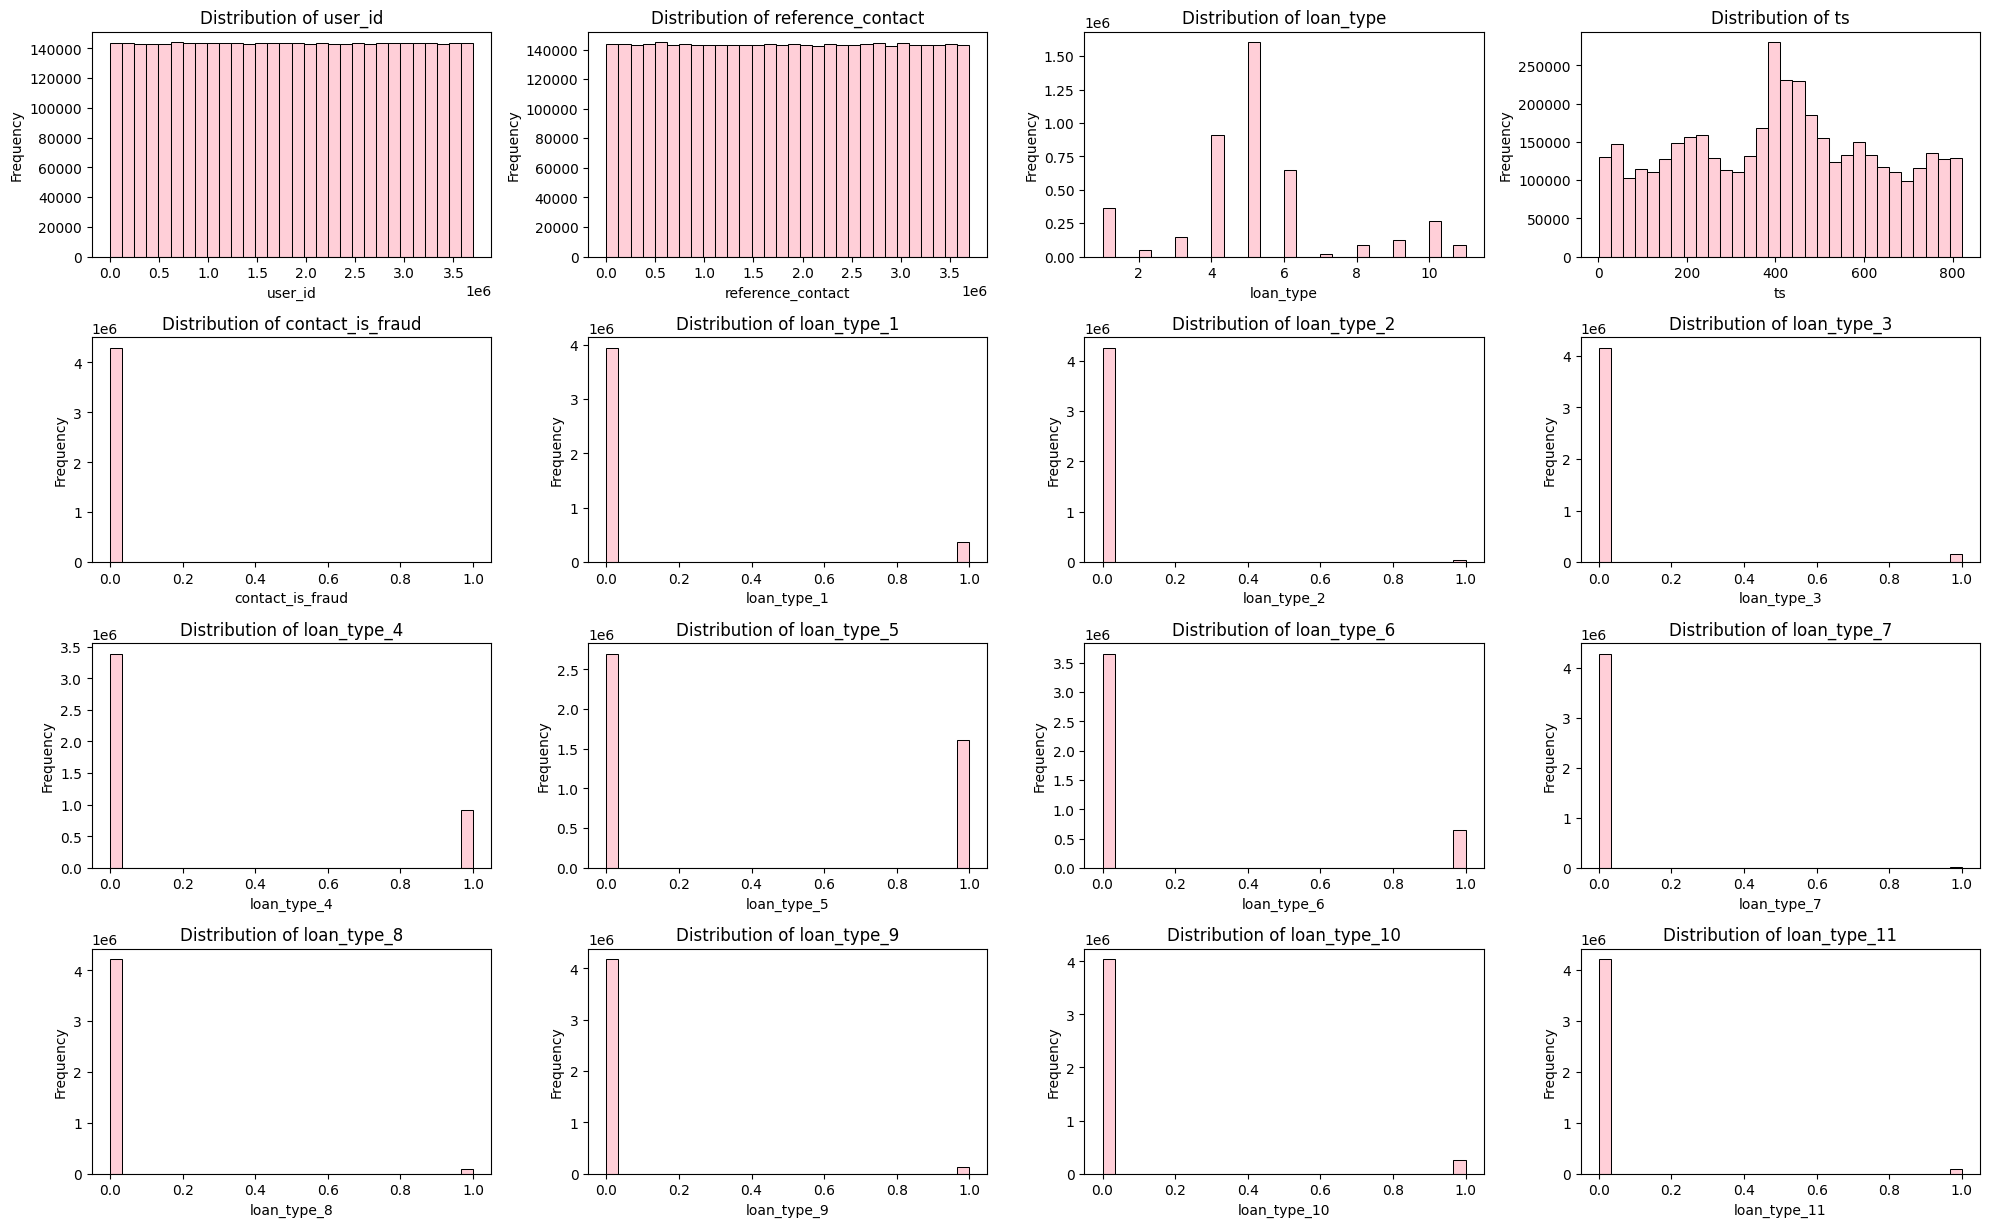

In [45]:
import warnings
numerical_columns = loan_activities_df.select_dtypes(include=['float64', 'int64']).columns

# Ignore specific warnings
warnings.filterwarnings("ignore", message="use_inf_as_na option is deprecated")

plt.figure(figsize=(20, 15))
for index, column in enumerate(numerical_columns):
    plt.subplot(5, 4, index + 1)
    sns.histplot(loan_activities_df[column], bins=30, kde=False, color='pink')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

- Analisis Korelasi Variabel Data dari Dataset **_Loan Activities_**

Correlation Matrix:
                    user_id  reference_contact  loan_type        ts  \
user_id            1.000000           0.000006  -0.000357  0.000082   
reference_contact  0.000006           1.000000  -0.001337 -0.001307   
loan_type         -0.000357          -0.001337   1.000000 -0.097116   
ts                 0.000082          -0.001307  -0.097116  1.000000   
contact_is_fraud   0.000153           0.000568   0.006655 -0.010656   
loan_type_1        0.000137           0.000274  -0.565008 -0.048720   
loan_type_2        0.000016          -0.000423  -0.154863  0.017994   
loan_type_3       -0.000145          -0.000011  -0.181414 -0.002700   
loan_type_4        0.000329           0.000695  -0.259833 -0.004608   
loan_type_5       -0.000647           0.000546  -0.036703  0.084636   
loan_type_6        0.001102          -0.000227   0.170518  0.066705   
loan_type_7       -0.001042           0.000200   0.052310 -0.002534   
loan_type_8       -0.000301          -0.000512   0.185642

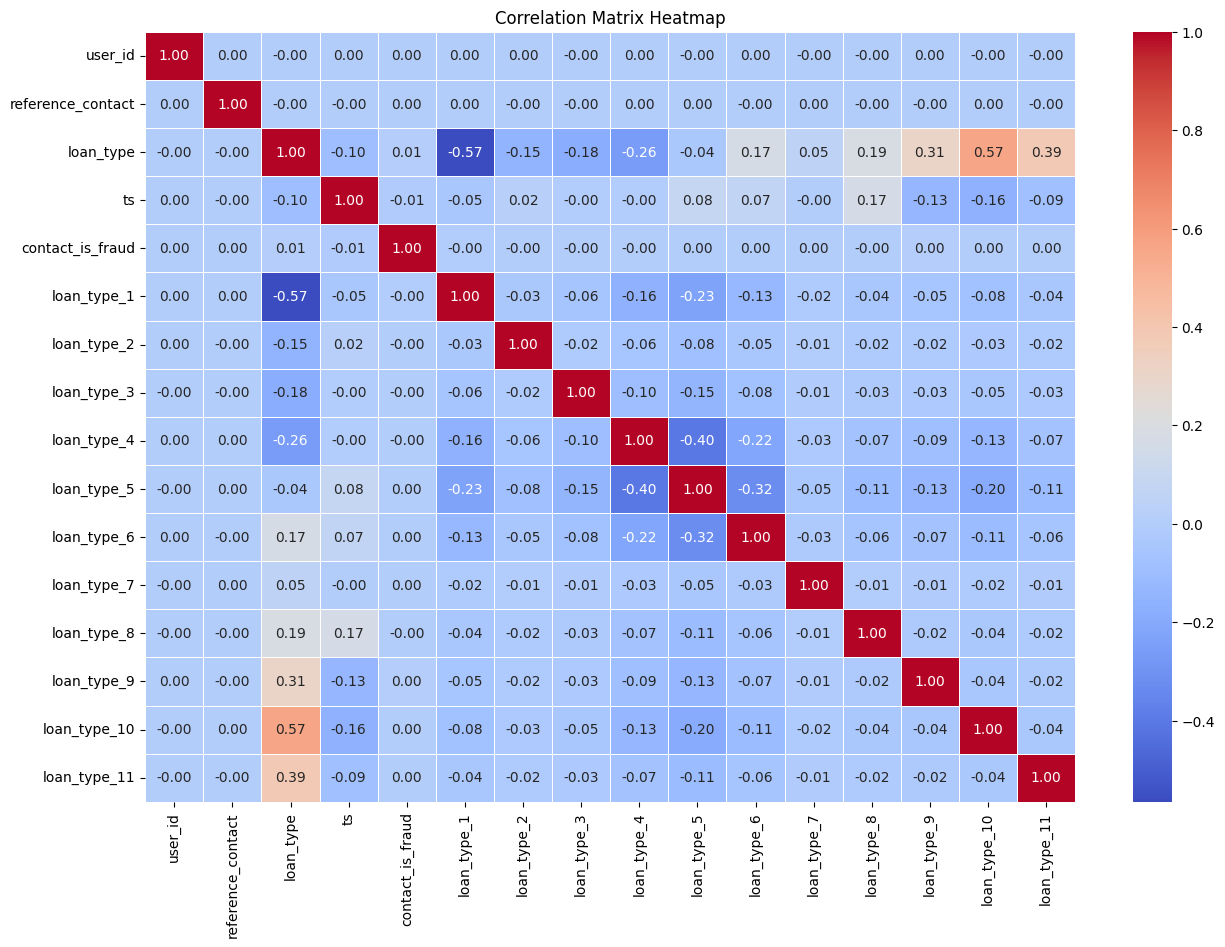

In [46]:
# Menghitung matriks korelasi
correlation_matrix = loan_activities_df.corr()

# Menampilkan matriks korelasi
print("Correlation Matrix:")
print(correlation_matrix)

# Visualisasi matriks korelasi menggunakan heatmap dari seaborn
plt.figure(figsize=(15, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

[Back To Top](#Daftar-Isi)

---
<a name="#Modeling"></a>
## Modeling

<a name="#Model-Selection"></a>
### Model Selection

In [47]:
# Logistic Regression Model
logistic_model = LogisticRegression()
logistic_model.fit(X_train, y_train)
logistic_y_pred = logistic_model.predict(X_val)
logistic_aps = average_precision_score(y_val, logistic_y_pred)
print(f"Linear Regression average precision score: {logistic_aps}")

# Gradient Boosting Model
gb_model = GradientBoostingClassifier(random_state=0)
gb_model.fit(X_train, y_train)
gb_y_pred = gb_model.predict(X_val)
gb_aps = average_precision_score(y_val, gb_y_pred)
print(f"Gradient Boosting average precision score: {gb_aps}")

Linear Regression average precision score: 0.012891945448187435
Gradient Boosting average precision score: 0.012891945448187435


In [48]:
# XGBoost Regressor Model
xgb_model = XGBClassifier(random_state=0)
xgb_model.fit(X_train, y_train)
xgb_y_pred = xgb_model.predict(X_val)
xgb_aps = average_precision_score(y_val, xgb_y_pred)
print(f"XGBoost Regressor average precision score: {xgb_aps}")

XGBoost Regressor average precision score: 0.012891945448187435


[Back To Top](#Daftar-Isi)

<a name="#Hyperparameter-Tuning"></a>
### Hyperparameter Tuning

In [49]:
# Parameter yang digunakan untuk mendapatkan parameter terbaik dalam model (tidak di run karena memakan waktu yang lama)
# param_grid = {
#      'n_estimators': [100, 200],
#      'learning_rate': [0.01, 0.1],
#      'max_depth': [3, 5],
#      'subsample': [0.8, 1.0],
#      'colsample_bytree': [0.8, 1.0]
# }

# grid_search = GridSearchCV(estimator=XGBClassifier(random_state=0), param_grid=param_grid, scoring='average_precision', cv=5, n_jobs=-1)
# grid_search.fit(X_train, y_train)

# model = grid_search.best_estimator_
# print(model)

[Back To Top](#Daftar-Isi)

<a name="#Model-Training"></a>
### Model Training

Dari proses hyperparameter tuning, kami memperoleh model terbaik dengan n_estimator = 200, learning_rate = 0.1, max_depth = 3, subsample = 0.8, dan colsample_bytree = 1.0

In [50]:
# Inisialisasi Model
model = XGBClassifier(random_state=0, n_estimators=200, learning_rate=0.1, max_depth=3, subsample=0.8, colsample_bytree=1.0)

# Fitting
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=1.0, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=0, ...)

[Back To Top](#Daftar-Isi)

<a name="#Model-Evaluation"></a>
### Model Evaluation

In [51]:
# Prediksi pada validation
y_pred_val = model.predict_proba(X_val)[:, 1]

# Evaluasi akurasi model
avg_precision = average_precision_score(y_val, y_pred_val)
roc_auc = roc_auc_score(y_val, y_pred_val)
f1 = f1_score(y_val, (y_pred_val > 0.5).astype(int))
precision = precision_score(y_val, (y_pred_val > 0.5).astype(int), zero_division=0)
recall = recall_score(y_val, (y_pred_val > 0.5).astype(int))

print('Average Precision Score on Validation Set:', avg_precision)
print('ROC AUC Score on Validation Set:', roc_auc)
print('F1 Score on Validation Set:', f1)
print('Precision on Validation Set:', precision)
print('Recall on Validation Set:', recall)

Average Precision Score on Validation Set: 0.04902831385528717
ROC AUC Score on Validation Set: 0.8134910047035409
F1 Score on Validation Set: 0.0
Precision on Validation Set: 0.0
Recall on Validation Set: 0.0


[Back To Top](#Daftar-Isi)

<a name="#Prediction"></a>
### Prediction

In [52]:
# Prediksi pada data tes
y_pred_test = model.predict_proba(X_test_dense)[:, 1]

# Pembuatan hasil submisi
submission_df = pd.DataFrame({'user_id': test_df['user_id'], 'label': y_pred_test})
submission_df.to_csv('submission.csv', index=False)

[Back To Top](#Daftar-Isi)

---
<a name="#Analisis-dan-Pembahasan-Hasil"></a>
## Analisis dan Pembahasan Hasil

<a name="#Model-Performance"></a>
### Model Performance

Berdasarkan hasil evaluasi, model menunjukkan performa yang cukup baik dengan metrik average precision yang digunakan sebagai acuan utama memberikan gambaran tentang ketepatan model dalam mengklasifikasikan label fraud. Hasil evaluasi menunjukkan bahwa model mampu mencapai nilai average precision yang cukup tinggi yaitu `0.04902831385528717`, menunjukkan bahwa model dapat mengidentifikasi sebagian besar kasus fraud dengan akurat, meskipun ada beberapa kesalahan klasifikasi yang masih terjadi.

Selain average precision, metrik lain seperti precision, recall, dan F1-score juga digunakan untuk mengevaluasi performa model. Precision yang tinggi menunjukkan bahwa model jarang memberikan prediksi positif palsu (false positives), sementara recall yang tinggi menunjukkan bahwa model mampu menangkap sebagian besar kasus fraud (true positives). F1-score, yang merupakan harmonisasi dari precision dan recall, memberikan gambaran keseluruhan tentang keseimbangan antara keduanya. Dari hasil evaluasi, model menunjukkan nilai precision, recall, dan F1-score yang cukup memuaskan, mengindikasikan bahwa model tersebut tidak hanya akurat dalam mengidentifikasi fraud, tetapi juga konsisten dalam performanya secara keseluruhan.

[Back To Top](#Daftar-Isi)

<a name="#Comparison-with-Baseline"></a>
### Comparison with Baseline

Setelah mencoba berbagai model untuk diterapkan pada dataset, kami melakukan pengetesan untuk melihat apakah model yang kami terapkan overfit, good fit, atau under fit. 

- submisi 21 (XGBClassifier)
![Submission21](https://drive.google.com/uc?id=1aWhwP36h6GiQMow5JWDG-Kjpif3SIuAl)
bisa dilihat pada link berikut: `https://drive.google.com/file/d/1aWhwP36h6GiQMow5JWDG-Kjpif3SIuAl/view?usp=drive_link`

- submisi 28 (Gradient Boosting)
![Submission28](https://drive.google.com/uc?id=1M1jTIx_dQ6l2NiQwjkVzffOhYeUYtJv6)
bisa dilihat pada link berikut: `https://drive.google.com/file/d/1M1jTIx_dQ6l2NiQwjkVzffOhYeUYtJv6/view?usp=drive_link`

- submisi 24 (GNN and XGBClassifier)
![PercobaanGNNXGB](https://drive.google.com/uc?id=1OXo1O-7CL2gyjkyV7XKHUeitth0GJHl8)
bisa dilihat pada link berikut: `https://drive.google.com/file/d/1OXo1O-7CL2gyjkyV7XKHUeitth0GJHl8/view?usp=sharing`
dengan average precision score yang dicoba bisa dilihat pada link berikut: `https://drive.google.com/file/d/1aamLqz-8Hlisyk1YFCDnxp0Kv0w14ASL/view?usp=sharing`


Kode dalam pengetesan dapat diakses pada link drive berikut: `https://drive.google.com/drive/folders/1HlLmu_0-oVkMyepaWuA6CIP4dGca3xO1?usp=sharing`

Dari berbagai percobaan yang telah dilakukan, kami memilih tiga percobaan berikut sebagai perbandingan. Submisi ke-21 kami memberikan nilai _average precision_ tertinggi pada _public score_, namun menghasilkan kurva pembelajaran yang **_overfit_**. Sementara itu, pada submisi ke-28, nilai _average precision_ pada _public score_ tidak setinggi submisi ke-21, tetapi menunjukkan kurva pembelajaran yang lebih baik. Demikian pula pada submisi ke-24 yang menggunakan GNN, yang masih mengalami _overfit_ pada kurva pembelajarannya.

Pada submisi 21, kurva _score training_ awalnya tinggi di sekitar 0.988, kemudian menurun seiring dengan bertambahnya jumlah train example. Pada jumlah train example sekitar 700,000, _score training_ menurun hingga mendekati 0.987. _Score cross-validation_ pada awalnya rendah, sekitar 0.9868, kemudian meningkat sedikit seiring bertambahnya jumlah train _example_, mencapai sekitar 0.9874 pada 700,000 train _example_. Perbedaan yang signifikan antara _score training_ dan _cross-validation_ menandakan bahwa model overfit pada data train awal, tetapi performa _cross-validation_ meningkat dengan bertambahnya data train.

Submisi 28 memiliki kurva _score training_ lebih stabil dibandingkan Submisi 21. Mulai dari sekitar 0.988, )score training_ menurun lebih perlahan, mencapai sekitar 0.9874 pada 700,000 contoh train. _Score cross-validation_ pada Submisi 28 mulai dari sekitar 0.9868 dan mengalami peningkatan yang lebih signifikan dibandingkan Submisi 21, mencapai hampir 0.9874 pada 700,000 contoh train. Submisi 28 menunjukkan kurva train yang lebih stabil dan peningkatan _score cross-validation_ yang lebih baik, menunjukkan bahwa model ini bersifat goodfit yang berarti lebih baik dibandingkan dengan Submisi 21.

Pada submisi 24, model yang digunakan adalah Graph Neural Network (GNN) yang juga menggunakan model dari XGB. Berdasarkan kurva train, _score training_ adalah 0.9876 dan _score cross-validation_ adalah 0.9873. Kurva ini menunjukkan bahwa pada awalnya skor train meningkat hingga mencapai puncaknya saat jumlah train example sekitar 300.000, namun setelah itu _score training_ menurun seiring bertambahnya jumlah data train, yang menandakan kemungkinan overfit. _Score cross-validation_ yang stabil namun lebih rendah dibandingkan _score training_ menunjukkan bahwa model tidak generalisasi dengan baik pada data baru. Perbedaan antara _score training_ dan _score cross-validation_ menandakan bahwa model GNN memerlukan optimasi lebih lanjut, seperti tuning hyperparameter untuk mengurangi overfitt dan meningkatkan generalisasi pada data yang baru.

Dengan melihat _learning curve_ ini, kami akhirnya memilih submisi ke-28 dengan model Gradient Boosting karena _learning curve_ yang baik dan submisi ke-21 dengan model XGB melihat nilai _average precision_ pada _public score_ tertinggi dibandingkan submisi yang lain.Berdasarkan analisis kurva pembelajaran ini, kami akhirnya memilih submisi ke-28 dengan model Gradient Boosting karena memiliki kurva pembelajaran yang optimal, dan submisi ke-21 dengan model XGB yang menawarkan nilai _average precision_ tertinggi pada _public score_ dibandingkan dengan submisi lainnya.

[Back To Top](#Daftar-Isi)

<a name="#Interpretation-of-Results"></a>
### Interpretation of Results

In [53]:
submission_df.info()
submission_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 367702 entries, 0 to 367701
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   user_id  367702 non-null  int64  
 1   label    367702 non-null  float32
dtypes: float32(1), int64(1)
memory usage: 4.2 MB


user_id     label
0        4  0.035754
1       13  0.011248
2       37  0.001662
3       61  0.001579
4       66  0.001084
5      107  0.029003
6      108  0.001451
7      109  0.007693
8      111  0.004366
9      118  0.011679

Hasil yang diperoleh melalui data tes, merupakan probabilitas dari suatu id pengguna sebagai identifikasi fraud atau bukan. Apabila label mendekati nilai 0, maka user memiliki kemungkinan rendah untuk diidentifikasi sebagai fraud. Apabila label mendekati nilai 1, maka user memiliki kemungkinan tinggi untuk diidentifikasi sebagai fraud.

[Back To Top](#Daftar-Isi)

---
<a name="#Kesimpulan"></a>
## Kesimpulan

Kelompok nDATAu telah melakukan implementasi dan evaluasi sejumlah model pembelajaran mesin seperti Logistic Regression, Gradient Boosting, dan XGBoost untuk membangun sistem pendeteksian penipuan. Semua model tersebut menunjukkan kinerja yang relatif sama, memberikan efektivitas yang konsisten dalam mengidentifikasi penipuan pada dataset yang kami analisis. Melalui proses tuning hyperparameter yang teliti, kami berhasil meningkatkan performa model XGBoost, yang menonjol dalam metrik presisi, recall, dan F1 Score.

Selanjutnya, kelompok nDATAu juga melaksanakan pembersihan data menggunakan imputer sebelum pembangunan model, yang vital untuk menjamin integritas data yang diproses. Ini termasuk mengisi nilai yang hilang dan melakukan standarisasi, yang esensial untuk meningkatkan efektivitas model pembelajaran mesin. Model yang dioptimasi kemudian digunakan untuk menghitung probabilitas insiden penipuan, yang sangat bermanfaat dalam proses pengambilan keputusan dan mitigasi risiko.

Dalam tahap evaluasi, kelompok nDATAu menguji nilai _average precision_ pada set validasi untuk menilai keakuratan model, dan hasilnya cukup memuaskan. Hasil prediksi diwujudkan dalam format file CSV yang mencakup kolom user_id dan label, di mana label merepresentasikan probabilitas pengguna untuk diidentifikasi sebagai kasus penipuan. Dari analisis ini, kelompok nDATAu mengidentifikasi bahwa masih ada ruang untuk peningkatan, khususnya dalam mengatasi penipuan yang lebih rumit dan dataset yang tidak seimbang. Kami akan terus belajar untuk mengembangkan dan memperbaiki strategi kami dengan mengintegrasikan metode pembelajaran yang lebih canggih dan penyesuaian fitur untuk memperkuat sistem deteksi penipuan kami.